# Entrenamiento arquitectura recurrente con espectrograma
-----
En este notebook se realiza el entrenamiento de la arquitectura recurrente sin aplicar normalización, para el desarrollo del trabajo de grado titulado: "Clasificación de patologías cardiovasculares con máquinas de aprendizaje profundo a partir de señales ECG".


# Importando Librerías

In [3]:
import optuna
import plotly
import numpy as np
import matplotlib.pyplot as plt
import os
from keras.utils.vis_utils import plot_model
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, optimizers, regularizers, initializers, callbacks
import random as python_random
from numpy.random import seed
np.random.seed(123)
tf.random.set_seed(11)
python_random.seed(123)
os.environ['PYTHONHASHSEED'] = '0'
from keras import backend as K
from keras.backend import set_session
from keras.backend import clear_session
from keras.backend import get_session
import tensorflow
import gc
from sklearn.metrics import confusion_matrix
import itertools
from keras.callbacks import ModelCheckpoint
import json


# Definiendo funciones

In [5]:
TAMANIO=60

def f1(y_true, y_pred):
    def recall(y_true, y_pred):
        """Recall metric.

        Only computes a batch-wise average of recall.

        Computes the recall, a metric for multi-label classification of
        how many relevant items are selected.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

    def precision(y_true, y_pred):
        """Precision metric.

        Only computes a batch-wise average of precision.

        Computes the precision, a metric for multi-label classification of
        how many selected items are relevant.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision
    precision = precision(y_true, y_pred)
    recall = recall(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))
def plot_confusion_matrix(cm, classes,ruta,
                        normalize=False,
                        title='Confusion matrix',
                        cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    # plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = np.round(cm.astype('float') / cm.sum(axis=1)[:, np.newaxis],2)
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2. 
    
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.gcf().set_size_inches(6,5)
    plt.savefig(ruta,dpi=300)
    plt.show()
def codificacion(tamano,unico=True,numero=0):
    #Vector de unos
    if unico==True:
        Y_train=np.ones(tamano)*numero
    else:
        for i in range(0,5):
            if i==0:
                Y_train=np.ones(tamano)*i
            else:
                vectorUnos=np.ones(tamano)
                Y_train=np.insert(Y_train,len(Y_train),vectorUnos*i,axis=0)
    return Y_train

# Reset Keras Session
def reset_keras():
    sess = get_session()
    clear_session()
    sess.close()
    sess = get_session()

    try:
        del classifier # this is from global space - change this as you need
    except:
        pass

    print(gc.collect()) # if it does something you should see a number as output

    # use the same config as you used to create the session
    config = tensorflow.compat.v1.ConfigProto()
    tf.compat.v1.GPUOptions(per_process_gpu_memory_fraction = 1)
    tf.compat.v1.GPUOptions(visible_device_list = "0")
    set_session(tf.compat.v1.Session(config=config))

def load_data_test_gru():
    # load your data using this function
    path='C:\\Users\jdani\\Documents\\TrabajoDeGrado\\BDConEspectrograma\\MatricesNumpyGuardadas_SN\\ECG_'
    #importando patologias
    ECG_Normal_Test=np.load(path+'Normal\\ECG_Normal_test.npy')
    ECG_SBR_Test=np.load(path+'SBR\\ECG_SBR_Original.npy')
    ECG_SBR_Test=ECG_SBR_Test[300:360,:,:]
    ECG_AFIB_Test=np.load(path+'AFIB\\ECG_AFIB_test.npy')
    ECG_STD_Test=np.load(path+'STD\\ECG_STD_test.npy')
    ECG_STE_Test=np.load(path+'STE\\ECG_STE_test.npy')

    filas_seleccionadas = np.random.choice(len(ECG_Normal_Test), size=TAMANIO, replace=False)
    ECG_Normal_Test = ECG_Normal_Test[filas_seleccionadas]
    filas_seleccionadas = np.random.choice(len(ECG_AFIB_Test), size=TAMANIO, replace=False)
    ECG_AFIB_Test = ECG_AFIB_Test[filas_seleccionadas]
    filas_seleccionadas = np.random.choice(len(ECG_STD_Test), size=TAMANIO, replace=False)
    ECG_STD_Test = ECG_STD_Test[filas_seleccionadas]
    filas_seleccionadas = np.random.choice(len(ECG_STE_Test), size=TAMANIO, replace=False)
    ECG_STE_Test = ECG_STE_Test[filas_seleccionadas]
    

    y_Normal_Test=codificacion(len(ECG_Normal_Test),True,0)
    y_SBR_Test=codificacion(len(ECG_SBR_Test),True,1)
    y_AFIB_Test=codificacion(len(ECG_AFIB_Test),True,2)
    y_STD_Test=codificacion(len(ECG_STD_Test),True,3)
    y_STE_Test=codificacion(len(ECG_STE_Test),True,4)
    
    #Uniendo canales
    ECG_Normal_Test=np.concatenate((ECG_Normal_Test[:,:,:,0],ECG_Normal_Test[:,:,:,1]),axis=1)
    ECG_SBR_Test=np.concatenate((ECG_SBR_Test[:,:,:,0],ECG_SBR_Test[:,:,:,1]),axis=1)
    ECG_AFIB_Test=np.concatenate((ECG_AFIB_Test[:,:,:,0],ECG_AFIB_Test[:,:,:,1]),axis=1)
    ECG_STE_Test=np.concatenate((ECG_STE_Test[:,:,:,0],ECG_STE_Test[:,:,:,1]),axis=1)
    ECG_STD_Test=np.concatenate((ECG_STD_Test[:,:,:,0],ECG_STD_Test[:,:,:,1]),axis=1)

    #Generando X_train
    X_test=np.concatenate((ECG_Normal_Test,
                                ECG_SBR_Test,
                                ECG_AFIB_Test,
                                ECG_STE_Test,
                                ECG_STD_Test))

    Y_test=np.insert(y_Normal_Test,len(y_Normal_Test),y_SBR_Test,axis=0)
    Y_test=np.insert(Y_test,len(Y_test),y_AFIB_Test,axis=0)
    Y_test=np.insert(Y_test,len(Y_test),y_STD_Test,axis=0)
    Y_test=np.insert(Y_test,len(Y_test),y_STE_Test,axis=0)    

    print('Tamaño datos test: '+ str(X_test.shape))
    print('Tamaño etiquetas de test: '+str(Y_test.shape))
    
    X_test=np.moveaxis(X_test,1,2)   
    return X_test,Y_test
def load_data_gru():
    path='C:\\Users\jdani\\Documents\\TrabajoDeGrado\\BDConEspectrograma\\MatricesNumpyGuardadas_SN\\ECG_'
    #importando patologias
    ECG_Normal_Original=np.load(path+'Normal\\ECG_Normal_Original.npy')
    ECG_SBR_Original=np.load(path+'SBR\\ECG_SBR_Original.npy')
    print(ECG_SBR_Original.shape)
    ECG_AFIB_Original=np.load(path+'AFIB\\ECG_AFIB_Original.npy')
    ECG_STD_Original=np.load(path+'STD\\ECG_STD_Original.npy')
    ECG_STE_Original=np.load(path+'STE\\ECG_STE_Original.npy')
        
    # partiendo base de datos y generando labels
    ECG_Normal_Train=ECG_Normal_Original[:,:,:]
    y_Normal_Train=codificacion(len(ECG_Normal_Train),True,0)
    ECG_SBR_Train=ECG_SBR_Original[:300,:,:]
    y_SBR_Train=codificacion(len(ECG_SBR_Train),True,1)
    ECG_AFIB_Train=ECG_AFIB_Original[:,:,:]
    y_AFIB_Train=codificacion(len(ECG_AFIB_Train),True,2)
    ECG_STD_Train=ECG_STD_Original[:,:,:]
    y_STD_Train=codificacion(len(ECG_STD_Train),True,3)
    ECG_STE_Train=ECG_STE_Original[:,:,:]
    y_STE_Train=codificacion(len(ECG_STE_Train),True,4)
    
    #Uniendo canales
    ECG_Normal_Train=np.concatenate((ECG_Normal_Train[:,:,:,0],ECG_Normal_Train[:,:,:,1]),axis=1)
    ECG_SBR_Train=np.concatenate((ECG_SBR_Train[:,:,:,0],ECG_SBR_Train[:,:,:,1]),axis=1)
    ECG_AFIB_Train=np.concatenate((ECG_AFIB_Train[:,:,:,0],ECG_AFIB_Train[:,:,:,1]),axis=1)
    ECG_STE_Train=np.concatenate((ECG_STE_Train[:,:,:,0],ECG_STE_Train[:,:,:,1]),axis=1)
    ECG_STD_Train=np.concatenate((ECG_STD_Train[:,:,:,0],ECG_STD_Train[:,:,:,1]),axis=1)
    
    #Generando Y
    Y_train=np.insert(y_Normal_Train,len(y_Normal_Train),y_SBR_Train,axis=0)
    Y_train=np.insert(Y_train,len(Y_train),y_AFIB_Train,axis=0)
    Y_train=np.insert(Y_train,len(Y_train),y_STD_Train,axis=0)
    Y_train=np.insert(Y_train,len(Y_train),y_STE_Train,axis=0)


    #Generando X_train

    X_train=np.concatenate((ECG_Normal_Train,
                                ECG_SBR_Train,
                                ECG_AFIB_Train,
                                ECG_STE_Train,
                                ECG_STD_Train))
    print('Tamaño datos entrenamiento: '+ str(X_train.shape))
    print('Tamaño etiquetas de entrenamiento: '+str(Y_train.shape))
    
    X_test,Y_test=load_data_test_gru()
    
    Y_train= keras.utils.to_categorical(Y_train)
    Y_test= keras.utils.to_categorical(Y_test)
    
    X_train=np.moveaxis(X_train,1,2)

    return X_train,Y_train,X_test,Y_test

In [3]:
X_train,Y_train,X_test,Y_test=load_data_gru()
X_train
X_test

print()
print()
print(X_train.shape)
print(Y_train.shape)
print(X_test.shape)
print(Y_test.shape)

(360, 51, 241, 2)
Tamaño datos entrenamiento: (10015, 102, 241)
Tamaño etiquetas de entrenamiento: (10015,)
Tamaño datos test: (300, 102, 241)
Tamaño etiquetas de test: (300,)


(10015, 241, 102)
(10015, 5)
(300, 241, 102)
(300, 5)


# Creando modelo para optimización con Optuna

In [3]:
#Definiendo constantes
EPOCAS=30
ciclo=0
mejores={}
def modelo_GRU(trial):
    # n_hidden=trial.suggest_int('n_hidden',256,1024)
    drop_path_rate = trial.suggest_float("drop_path_rate", 0.5, 0.8, step=0.1)
    strides_num=trial.suggest_int('strides',1,10)
    # kernel_sizes=trial.suggest_int('kernel_sizes',3,100)
    kernel_sizes=trial.suggest_categorical('kernel_sizes', [3,6,9,12,15,18,21,24,25])
    n_filters=trial.suggest_int('n_filters',16,256)
    # input_shape = (1, 51, 482)
    input_shape = (1, 241, 102)
    # Regularización L2
    ModelGRU=keras.models.Sequential()

    ModelGRU.add(keras.layers.Conv1D(filters=n_filters,kernel_size=kernel_sizes,strides=strides_num,input_shape=input_shape[1:]))
    ModelGRU.add(keras.layers.BatchNormalization())
    ModelGRU.add(keras.layers.Activation('relu'))
    ModelGRU.add(keras.layers.Dropout(drop_path_rate))

    ModelGRU.add(keras.layers.GRU(units=128,return_sequences=True))
    ModelGRU.add(keras.layers.BatchNormalization())
    ModelGRU.add(keras.layers.Dropout(drop_path_rate))

    ModelGRU.add(keras.layers.GRU(units=128,return_sequences=True))
    ModelGRU.add(keras.layers.BatchNormalization())
    ModelGRU.add(keras.layers.Dropout(drop_path_rate))
    
    ModelGRU.add(keras.layers.TimeDistributed(keras.layers.Dense(128,activation="tanh",activity_regularizer=regularizers.L1L2(1e-3))))
    ModelGRU.add(keras.layers.Dropout(drop_path_rate))
    ModelGRU.add(keras.layers.Flatten())
    # keras.layers.Dense(128,activation="tanh",activity_regularizer=regularizers.L2(1e-5))
    ModelGRU.add(keras.layers.Dense(64,activation="tanh",activity_regularizer=regularizers.L1L2(1e-3)))
    ModelGRU.add(keras.layers.Dropout(drop_path_rate))
    ModelGRU.add(keras.layers.Dense(5,activation="softmax",))  
    ModelGRU.summary()
    
    return ModelGRU

def create_optimizer_GRU(trial):
    # We optimize the choice of optimizers as well as their parameters.
    kwargs = {}
    # optimizer_options = ["RMSprop", "Adam", "SGD"]
    optimizer_selected = "Adam"
    # optimizer_selected = trial.suggest_categorical("optimizer", optimizer_options)
    if optimizer_selected == "RMSprop":
        kwargs["learning_rate"] = trial.suggest_float(
            "rmsprop_learning_rate", 1e-5, 1e-1, log=True
        )
        kwargs["decay"] = trial.suggest_float("rmsprop_decay", 0.85, 0.99)
        kwargs["momentum"] = trial.suggest_float("rmsprop_momentum", 1e-5, 1e-1, log=True)
    elif optimizer_selected == "Adam":
        kwargs["learning_rate"] = trial.suggest_float("adam_learning_rate", 1e-5, 1e-1, log=True)
    elif optimizer_selected == "SGD":
        kwargs["learning_rate"] = trial.suggest_float(
            "sgd_opt_learning_rate", 1e-5, 1e-1, log=True
        )
        kwargs["momentum"] = trial.suggest_float("sgd_opt_momentum", 1e-5, 1e-1, log=True)

    optimizer = getattr(tf.optimizers, optimizer_selected)(**kwargs)
    return optimizer

def learn_GRU(trial,model, optimizer, X,Y,X_test,Y_test):
    global ciclo
    global mejores
    batches=trial.suggest_int('batches',64,256)
    # val_split=trial.suggest_float('val_split',0.1,0.2,step=0.05)
    model.compile(loss='categorical_crossentropy',
              optimizer=optimizer,
              metrics=['accuracy',tf.keras.metrics.AUC(),f1])
    Stop = callbacks.EarlyStopping(monitor='accuracy', mode='max', verbose=1, patience=10)
    ruta_modelo='C:\\Users\\jdani\\Documents\\TrabajoDeGrado\\Arquitecturas\\ArquitecturaRecurrente\\ModelosCheckpointsOptuna\\SN\\'
    ruta_modelo_trial=ruta_modelo+'mejor_modelo_trial'+str(ciclo)+'.h5'
    Checkpoint = ModelCheckpoint(ruta_modelo_trial, monitor="val_accuracy", save_best_only=True, mode="max")
    history_GRU=model.fit(X,Y,verbose=1,validation_data=(X_test,Y_test),epochs=EPOCAS,batch_size=batches,callbacks=[Stop, Checkpoint])
    ciclo+=1
    mejores['trial '+str(ciclo)]=Checkpoint.best
    reset_keras()
    gc.collect()
    return history_GRU.history['val_accuracy'][-1]

def objective_GRU(trial):
    ##Datos
    X_train,y_train,X_test,y_test=load_data_gru()
    
    # Clear clutter from previous session graphs.
    # keras.backend.clear_session()
    #Contruyendo modelo y optimizador
    model=modelo_GRU(trial)
    optimizer=create_optimizer_GRU(trial)
    
    #Entrenando y validando
    loss=learn_GRU(trial,model,optimizer,X_train,y_train,X_test,y_test)
    # reset_keras()
    return loss

In [4]:
study_GRU=optuna.create_study(direction="maximize") #Para minimizar la función de pérdida

[I 2023-04-07 23:25:32,086] A new study created in memory with name: no-name-8b45ef28-d8c0-4194-a2eb-1859cff3a68f


In [5]:
study_GRU.optimize(objective_GRU,n_trials=50)

(360, 51, 241, 2)
Tamaño datos entrenamiento: (10015, 102, 241)
Tamaño etiquetas de entrenamiento: (10015,)
Tamaño datos test: (300, 102, 241)
Tamaño etiquetas de test: (300,)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 224, 92)           169004    
                                                                 
 batch_normalization (BatchN  (None, 224, 92)          368       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 224, 92)           0         
                                                                 
 dropout (Dropout)           (None, 224, 92)           0         
                                                                 
 gru (GRU)                   (None, 224, 128)          85248     
            

[I 2023-04-07 23:31:56,905] Trial 0 finished with value: 0.5799999833106995 and parameters: {'drop_path_rate': 0.7, 'strides': 1, 'kernel_sizes': 18, 'n_filters': 92, 'adam_learning_rate': 0.005009992838010726, 'batches': 168}. Best is trial 0 with value: 0.5799999833106995.


(360, 51, 241, 2)
Tamaño datos entrenamiento: (10015, 102, 241)
Tamaño etiquetas de entrenamiento: (10015,)
Tamaño datos test: (300, 102, 241)
Tamaño etiquetas de test: (300,)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 26, 107)           98333     
                                                                 
 batch_normalization (BatchN  (None, 26, 107)          428       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 26, 107)           0         
                                                                 
 dropout (Dropout)           (None, 26, 107)           0         
                                                                 
 gru (GRU)                   (None, 26, 128)           91008     
            

[I 2023-04-07 23:32:29,852] Trial 1 finished with value: 0.2866666615009308 and parameters: {'drop_path_rate': 0.5, 'strides': 9, 'kernel_sizes': 9, 'n_filters': 107, 'adam_learning_rate': 0.020343132686391065, 'batches': 146}. Best is trial 0 with value: 0.5799999833106995.


(360, 51, 241, 2)
Tamaño datos entrenamiento: (10015, 102, 241)
Tamaño etiquetas de entrenamiento: (10015,)
Tamaño datos test: (300, 102, 241)
Tamaño etiquetas de test: (300,)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 40, 91)            55783     
                                                                 
 batch_normalization (BatchN  (None, 40, 91)           364       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 40, 91)            0         
                                                                 
 dropout (Dropout)           (None, 40, 91)            0         
                                                                 
 gru (GRU)                   (None, 40, 128)           84864     
            

[I 2023-04-07 23:33:18,395] Trial 2 finished with value: 0.5899999737739563 and parameters: {'drop_path_rate': 0.7, 'strides': 6, 'kernel_sizes': 6, 'n_filters': 91, 'adam_learning_rate': 0.006847476116842353, 'batches': 230}. Best is trial 2 with value: 0.5899999737739563.


(360, 51, 241, 2)
Tamaño datos entrenamiento: (10015, 102, 241)
Tamaño etiquetas de entrenamiento: (10015,)
Tamaño datos test: (300, 102, 241)
Tamaño etiquetas de test: (300,)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 38, 50)            91850     
                                                                 
 batch_normalization (BatchN  (None, 38, 50)           200       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 38, 50)            0         
                                                                 
 dropout (Dropout)           (None, 38, 50)            0         
                                                                 
 gru (GRU)                   (None, 38, 128)           69120     
            

[I 2023-04-07 23:34:44,285] Trial 3 finished with value: 0.6766666769981384 and parameters: {'drop_path_rate': 0.8, 'strides': 6, 'kernel_sizes': 18, 'n_filters': 50, 'adam_learning_rate': 0.00030661063796342224, 'batches': 96}. Best is trial 3 with value: 0.6766666769981384.


(360, 51, 241, 2)
Tamaño datos entrenamiento: (10015, 102, 241)
Tamaño etiquetas de entrenamiento: (10015,)
Tamaño datos test: (300, 102, 241)
Tamaño etiquetas de test: (300,)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 23, 85)            130135    
                                                                 
 batch_normalization (BatchN  (None, 23, 85)           340       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 23, 85)            0         
                                                                 
 dropout (Dropout)           (None, 23, 85)            0         
                                                                 
 gru (GRU)                   (None, 23, 128)           82560     
            

[I 2023-04-07 23:35:50,943] Trial 4 finished with value: 0.3333333432674408 and parameters: {'drop_path_rate': 0.7, 'strides': 10, 'kernel_sizes': 15, 'n_filters': 85, 'adam_learning_rate': 0.0011439872646892915, 'batches': 130}. Best is trial 3 with value: 0.6766666769981384.


(360, 51, 241, 2)
Tamaño datos entrenamiento: (10015, 102, 241)
Tamaño etiquetas de entrenamiento: (10015,)
Tamaño datos test: (300, 102, 241)
Tamaño etiquetas de test: (300,)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 33, 176)           215600    
                                                                 
 batch_normalization (BatchN  (None, 33, 176)          704       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 33, 176)           0         
                                                                 
 dropout (Dropout)           (None, 33, 176)           0         
                                                                 
 gru (GRU)                   (None, 33, 128)           117504    
            

[I 2023-04-07 23:36:58,361] Trial 5 finished with value: 0.6266666650772095 and parameters: {'drop_path_rate': 0.7, 'strides': 7, 'kernel_sizes': 12, 'n_filters': 176, 'adam_learning_rate': 3.0047691333069698e-05, 'batches': 247}. Best is trial 3 with value: 0.6766666769981384.


(360, 51, 241, 2)
Tamaño datos entrenamiento: (10015, 102, 241)
Tamaño etiquetas de entrenamiento: (10015,)
Tamaño datos test: (300, 102, 241)
Tamaño etiquetas de test: (300,)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 73, 201)           512751    
                                                                 
 batch_normalization (BatchN  (None, 73, 201)          804       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 73, 201)           0         
                                                                 
 dropout (Dropout)           (None, 73, 201)           0         
                                                                 
 gru (GRU)                   (None, 73, 128)           127104    
            

[I 2023-04-07 23:39:17,082] Trial 6 finished with value: 0.49000000953674316 and parameters: {'drop_path_rate': 0.8, 'strides': 3, 'kernel_sizes': 25, 'n_filters': 201, 'adam_learning_rate': 9.058677652600851e-05, 'batches': 198}. Best is trial 3 with value: 0.6766666769981384.


(360, 51, 241, 2)
Tamaño datos entrenamiento: (10015, 102, 241)
Tamaño etiquetas de entrenamiento: (10015,)
Tamaño datos test: (300, 102, 241)
Tamaño etiquetas de test: (300,)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 73, 113)           288263    
                                                                 
 batch_normalization (BatchN  (None, 73, 113)          452       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 73, 113)           0         
                                                                 
 dropout (Dropout)           (None, 73, 113)           0         
                                                                 
 gru (GRU)                   (None, 73, 128)           93312     
            

[I 2023-04-07 23:41:11,493] Trial 7 finished with value: 0.46000000834465027 and parameters: {'drop_path_rate': 0.6, 'strides': 3, 'kernel_sizes': 25, 'n_filters': 113, 'adam_learning_rate': 0.00012194616984489982, 'batches': 161}. Best is trial 3 with value: 0.6766666769981384.


(360, 51, 241, 2)
Tamaño datos entrenamiento: (10015, 102, 241)
Tamaño etiquetas de entrenamiento: (10015,)
Tamaño datos test: (300, 102, 241)
Tamaño etiquetas de test: (300,)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 58, 87)            106575    
                                                                 
 batch_normalization (BatchN  (None, 58, 87)           348       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 58, 87)            0         
                                                                 
 dropout (Dropout)           (None, 58, 87)            0         
                                                                 
 gru (GRU)                   (None, 58, 128)           83328     
            

[I 2023-04-07 23:42:00,006] Trial 8 finished with value: 0.2199999988079071 and parameters: {'drop_path_rate': 0.5, 'strides': 4, 'kernel_sizes': 12, 'n_filters': 87, 'adam_learning_rate': 0.019189363752900385, 'batches': 117}. Best is trial 3 with value: 0.6766666769981384.


(360, 51, 241, 2)
Tamaño datos entrenamiento: (10015, 102, 241)
Tamaño etiquetas de entrenamiento: (10015,)
Tamaño datos test: (300, 102, 241)
Tamaño etiquetas de test: (300,)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 57, 201)           307731    
                                                                 
 batch_normalization (BatchN  (None, 57, 201)          804       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 57, 201)           0         
                                                                 
 dropout (Dropout)           (None, 57, 201)           0         
                                                                 
 gru (GRU)                   (None, 57, 128)           127104    
            

[I 2023-04-07 23:42:45,684] Trial 9 finished with value: 0.20000000298023224 and parameters: {'drop_path_rate': 0.7, 'strides': 4, 'kernel_sizes': 15, 'n_filters': 201, 'adam_learning_rate': 0.035873869563225094, 'batches': 185}. Best is trial 3 with value: 0.6766666769981384.


(360, 51, 241, 2)
Tamaño datos entrenamiento: (10015, 102, 241)
Tamaño etiquetas de entrenamiento: (10015,)
Tamaño datos test: (300, 102, 241)
Tamaño etiquetas de test: (300,)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 28, 20)            42860     
                                                                 
 batch_normalization (BatchN  (None, 28, 20)           80        
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 28, 20)            0         
                                                                 
 dropout (Dropout)           (None, 28, 20)            0         
                                                                 
 gru (GRU)                   (None, 28, 128)           57600     
            

[I 2023-04-07 23:44:25,600] Trial 10 finished with value: 0.2933333218097687 and parameters: {'drop_path_rate': 0.8, 'strides': 8, 'kernel_sizes': 21, 'n_filters': 20, 'adam_learning_rate': 1.1992377903983195e-05, 'batches': 66}. Best is trial 3 with value: 0.6766666769981384.


(360, 51, 241, 2)
Tamaño datos entrenamiento: (10015, 102, 241)
Tamaño etiquetas de entrenamiento: (10015,)
Tamaño datos test: (300, 102, 241)
Tamaño etiquetas de test: (300,)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 32, 163)           399187    
                                                                 
 batch_normalization (BatchN  (None, 32, 163)          652       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 32, 163)           0         
                                                                 
 dropout (Dropout)           (None, 32, 163)           0         
                                                                 
 gru (GRU)                   (None, 32, 128)           112512    
            

[I 2023-04-07 23:45:35,774] Trial 11 finished with value: 0.4399999976158142 and parameters: {'drop_path_rate': 0.8, 'strides': 7, 'kernel_sizes': 24, 'n_filters': 163, 'adam_learning_rate': 0.00017400455651341332, 'batches': 254}. Best is trial 3 with value: 0.6766666769981384.


(360, 51, 241, 2)
Tamaño datos entrenamiento: (10015, 102, 241)
Tamaño etiquetas de entrenamiento: (10015,)
Tamaño datos test: (300, 102, 241)
Tamaño etiquetas de test: (300,)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 39, 256)           313600    
                                                                 
 batch_normalization (BatchN  (None, 39, 256)          1024      
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 39, 256)           0         
                                                                 
 dropout (Dropout)           (None, 39, 256)           0         
                                                                 
 gru (GRU)                   (None, 39, 128)           148224    
            

[I 2023-04-07 23:47:20,128] Trial 12 finished with value: 0.8100000023841858 and parameters: {'drop_path_rate': 0.6, 'strides': 6, 'kernel_sizes': 12, 'n_filters': 256, 'adam_learning_rate': 1.3698191665729949e-05, 'batches': 83}. Best is trial 12 with value: 0.8100000023841858.


(360, 51, 241, 2)
Tamaño datos entrenamiento: (10015, 102, 241)
Tamaño etiquetas de entrenamiento: (10015,)
Tamaño datos test: (300, 102, 241)
Tamaño etiquetas de test: (300,)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 48, 244)           74908     
                                                                 
 batch_normalization (BatchN  (None, 48, 244)          976       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 48, 244)           0         
                                                                 
 dropout (Dropout)           (None, 48, 244)           0         
                                                                 
 gru (GRU)                   (None, 48, 128)           143616    
            

[I 2023-04-07 23:49:11,715] Trial 13 finished with value: 0.38999998569488525 and parameters: {'drop_path_rate': 0.6, 'strides': 5, 'kernel_sizes': 3, 'n_filters': 244, 'adam_learning_rate': 0.0004495605433387922, 'batches': 79}. Best is trial 12 with value: 0.8100000023841858.


(360, 51, 241, 2)
Tamaño datos entrenamiento: (10015, 102, 241)
Tamaño etiquetas de entrenamiento: (10015,)
Tamaño datos test: (300, 102, 241)
Tamaño etiquetas de test: (300,)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 38, 28)            51436     
                                                                 
 batch_normalization (BatchN  (None, 38, 28)           112       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 38, 28)            0         
                                                                 
 dropout (Dropout)           (None, 38, 28)            0         
                                                                 
 gru (GRU)                   (None, 38, 128)           60672     
            

[I 2023-04-07 23:50:35,891] Trial 14 finished with value: 0.6566666960716248 and parameters: {'drop_path_rate': 0.6, 'strides': 6, 'kernel_sizes': 18, 'n_filters': 28, 'adam_learning_rate': 1.1740152061324605e-05, 'batches': 95}. Best is trial 12 with value: 0.8100000023841858.


41842
(360, 51, 241, 2)
Tamaño datos entrenamiento: (10015, 102, 241)
Tamaño etiquetas de entrenamiento: (10015,)
Tamaño datos test: (300, 102, 241)
Tamaño etiquetas de test: (300,)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 28, 253)           464761    
                                                                 
 batch_normalization (BatchN  (None, 28, 253)          1012      
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 28, 253)           0         
                                                                 
 dropout (Dropout)           (None, 28, 253)           0         
                                                                 
 gru (GRU)                   (None, 28, 128)           147072    
      

[I 2023-04-07 23:52:02,205] Trial 15 finished with value: 0.7733333110809326 and parameters: {'drop_path_rate': 0.6, 'strides': 8, 'kernel_sizes': 18, 'n_filters': 253, 'adam_learning_rate': 3.501828253594673e-05, 'batches': 102}. Best is trial 12 with value: 0.8100000023841858.


41842
(360, 51, 241, 2)
Tamaño datos entrenamiento: (10015, 102, 241)
Tamaño etiquetas de entrenamiento: (10015,)
Tamaño datos test: (300, 102, 241)
Tamaño etiquetas de test: (300,)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 29, 249)           305025    
                                                                 
 batch_normalization (BatchN  (None, 29, 249)          996       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 29, 249)           0         
                                                                 
 dropout (Dropout)           (None, 29, 249)           0         
                                                                 
 gru (GRU)                   (None, 29, 128)           145536    
      

[I 2023-04-07 23:53:24,212] Trial 16 finished with value: 0.8366666436195374 and parameters: {'drop_path_rate': 0.5, 'strides': 8, 'kernel_sizes': 12, 'n_filters': 249, 'adam_learning_rate': 4.257930396199582e-05, 'batches': 110}. Best is trial 16 with value: 0.8366666436195374.


(360, 51, 241, 2)
Tamaño datos entrenamiento: (10015, 102, 241)
Tamaño etiquetas de entrenamiento: (10015,)
Tamaño datos test: (300, 102, 241)
Tamaño etiquetas de test: (300,)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 23, 218)           267050    
                                                                 
 batch_normalization (BatchN  (None, 23, 218)          872       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 23, 218)           0         
                                                                 
 dropout (Dropout)           (None, 23, 218)           0         
                                                                 
 gru (GRU)                   (None, 23, 128)           133632    
            

[I 2023-04-07 23:54:32,773] Trial 17 finished with value: 0.6100000143051147 and parameters: {'drop_path_rate': 0.5, 'strides': 10, 'kernel_sizes': 12, 'n_filters': 218, 'adam_learning_rate': 5.566047058290131e-05, 'batches': 134}. Best is trial 16 with value: 0.8366666436195374.


(360, 51, 241, 2)
Tamaño datos entrenamiento: (10015, 102, 241)
Tamaño etiquetas de entrenamiento: (10015,)
Tamaño datos test: (300, 102, 241)
Tamaño etiquetas de test: (300,)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 29, 231)           282975    
                                                                 
 batch_normalization (BatchN  (None, 29, 231)          924       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 29, 231)           0         
                                                                 
 dropout (Dropout)           (None, 29, 231)           0         
                                                                 
 gru (GRU)                   (None, 29, 128)           138624    
            

[I 2023-04-07 23:56:17,765] Trial 18 finished with value: 0.8133333325386047 and parameters: {'drop_path_rate': 0.5, 'strides': 8, 'kernel_sizes': 12, 'n_filters': 231, 'adam_learning_rate': 2.2857218093892326e-05, 'batches': 69}. Best is trial 16 with value: 0.8366666436195374.


(360, 51, 241, 2)
Tamaño datos entrenamiento: (10015, 102, 241)
Tamaño etiquetas de entrenamiento: (10015,)
Tamaño datos test: (300, 102, 241)
Tamaño etiquetas de test: (300,)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 29, 146)           178850    
                                                                 
 batch_normalization (BatchN  (None, 29, 146)          584       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 29, 146)           0         
                                                                 
 dropout (Dropout)           (None, 29, 146)           0         
                                                                 
 gru (GRU)                   (None, 29, 128)           105984    
            

[I 2023-04-07 23:57:34,457] Trial 19 finished with value: 0.753333330154419 and parameters: {'drop_path_rate': 0.5, 'strides': 8, 'kernel_sizes': 12, 'n_filters': 146, 'adam_learning_rate': 4.098084038118991e-05, 'batches': 113}. Best is trial 16 with value: 0.8366666436195374.


(360, 51, 241, 2)
Tamaño datos entrenamiento: (10015, 102, 241)
Tamaño etiquetas de entrenamiento: (10015,)
Tamaño datos test: (300, 102, 241)
Tamaño etiquetas de test: (300,)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 27, 225)           69075     
                                                                 
 batch_normalization (BatchN  (None, 27, 225)          900       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 27, 225)           0         
                                                                 
 dropout (Dropout)           (None, 27, 225)           0         
                                                                 
 gru (GRU)                   (None, 27, 128)           136320    
            

[I 2023-04-07 23:59:08,260] Trial 20 finished with value: 0.4566666781902313 and parameters: {'drop_path_rate': 0.5, 'strides': 9, 'kernel_sizes': 3, 'n_filters': 225, 'adam_learning_rate': 0.0007481595495890608, 'batches': 73}. Best is trial 16 with value: 0.8366666436195374.


41842
(360, 51, 241, 2)
Tamaño datos entrenamiento: (10015, 102, 241)
Tamaño etiquetas de entrenamiento: (10015,)
Tamaño datos test: (300, 102, 241)
Tamaño etiquetas de test: (300,)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 33, 254)           311150    
                                                                 
 batch_normalization (BatchN  (None, 33, 254)          1016      
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 33, 254)           0         
                                                                 
 dropout (Dropout)           (None, 33, 254)           0         
                                                                 
 gru (GRU)                   (None, 33, 128)           147456    
      

[I 2023-04-08 00:00:45,933] Trial 21 finished with value: 0.7133333086967468 and parameters: {'drop_path_rate': 0.5, 'strides': 7, 'kernel_sizes': 12, 'n_filters': 254, 'adam_learning_rate': 1.1856885976414532e-05, 'batches': 83}. Best is trial 16 with value: 0.8366666436195374.


(360, 51, 241, 2)
Tamaño datos entrenamiento: (10015, 102, 241)
Tamaño etiquetas de entrenamiento: (10015,)
Tamaño datos test: (300, 102, 241)
Tamaño etiquetas de test: (300,)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 26, 234)           286650    
                                                                 
 batch_normalization (BatchN  (None, 26, 234)          936       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 26, 234)           0         
                                                                 
 dropout (Dropout)           (None, 26, 234)           0         
                                                                 
 gru (GRU)                   (None, 26, 128)           139776    
            

[I 2023-04-08 00:02:14,297] Trial 22 finished with value: 0.7766666412353516 and parameters: {'drop_path_rate': 0.6, 'strides': 9, 'kernel_sizes': 12, 'n_filters': 234, 'adam_learning_rate': 1.887939419733712e-05, 'batches': 88}. Best is trial 16 with value: 0.8366666436195374.


(360, 51, 241, 2)
Tamaño datos entrenamiento: (10015, 102, 241)
Tamaño etiquetas de entrenamiento: (10015,)
Tamaño datos test: (300, 102, 241)
Tamaño etiquetas de test: (300,)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 46, 203)           248675    
                                                                 
 batch_normalization (BatchN  (None, 46, 203)          812       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 46, 203)           0         
                                                                 
 dropout (Dropout)           (None, 46, 203)           0         
                                                                 
 gru (GRU)                   (None, 46, 128)           127872    
            

[I 2023-04-08 00:04:18,657] Trial 23 finished with value: 0.8066666722297668 and parameters: {'drop_path_rate': 0.5, 'strides': 5, 'kernel_sizes': 12, 'n_filters': 203, 'adam_learning_rate': 6.601858019688059e-05, 'batches': 65}. Best is trial 16 with value: 0.8366666436195374.


(360, 51, 241, 2)
Tamaño datos entrenamiento: (10015, 102, 241)
Tamaño etiquetas de entrenamiento: (10015,)
Tamaño datos test: (300, 102, 241)
Tamaño etiquetas de test: (300,)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 34, 176)           161744    
                                                                 
 batch_normalization (BatchN  (None, 34, 176)          704       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 34, 176)           0         
                                                                 
 dropout (Dropout)           (None, 34, 176)           0         
                                                                 
 gru (GRU)                   (None, 34, 128)           117504    
            

[I 2023-04-08 00:05:40,237] Trial 24 finished with value: 0.7866666913032532 and parameters: {'drop_path_rate': 0.6, 'strides': 7, 'kernel_sizes': 9, 'n_filters': 176, 'adam_learning_rate': 2.644386659698112e-05, 'batches': 113}. Best is trial 16 with value: 0.8366666436195374.


(360, 51, 241, 2)
Tamaño datos entrenamiento: (10015, 102, 241)
Tamaño etiquetas de entrenamiento: (10015,)
Tamaño datos test: (300, 102, 241)
Tamaño etiquetas de test: (300,)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 28, 218)           467174    
                                                                 
 batch_normalization (BatchN  (None, 28, 218)          872       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 28, 218)           0         
                                                                 
 dropout (Dropout)           (None, 28, 218)           0         
                                                                 
 gru (GRU)                   (None, 28, 128)           133632    
            

[I 2023-04-08 00:06:58,507] Trial 25 finished with value: 0.8133333325386047 and parameters: {'drop_path_rate': 0.5, 'strides': 8, 'kernel_sizes': 21, 'n_filters': 218, 'adam_learning_rate': 2.2712706728779328e-05, 'batches': 132}. Best is trial 16 with value: 0.8366666436195374.


(360, 51, 241, 2)
Tamaño datos entrenamiento: (10015, 102, 241)
Tamaño etiquetas de entrenamiento: (10015,)
Tamaño datos test: (300, 102, 241)
Tamaño etiquetas de test: (300,)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 28, 212)           454316    
                                                                 
 batch_normalization (BatchN  (None, 28, 212)          848       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 28, 212)           0         
                                                                 
 dropout (Dropout)           (None, 28, 212)           0         
                                                                 
 gru (GRU)                   (None, 28, 128)           131328    
            

[I 2023-04-08 00:08:15,265] Trial 26 finished with value: 0.7433333396911621 and parameters: {'drop_path_rate': 0.5, 'strides': 8, 'kernel_sizes': 21, 'n_filters': 212, 'adam_learning_rate': 6.77662409060284e-05, 'batches': 141}. Best is trial 16 with value: 0.8366666436195374.


(360, 51, 241, 2)
Tamaño datos entrenamiento: (10015, 102, 241)
Tamaño etiquetas de entrenamiento: (10015,)
Tamaño datos test: (300, 102, 241)
Tamaño etiquetas de test: (300,)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 25, 231)           495033    
                                                                 
 batch_normalization (BatchN  (None, 25, 231)          924       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 25, 231)           0         
                                                                 
 dropout (Dropout)           (None, 25, 231)           0         
                                                                 
 gru (GRU)                   (None, 25, 128)           138624    
            

[I 2023-04-08 00:09:31,514] Trial 27 finished with value: 0.39666667580604553 and parameters: {'drop_path_rate': 0.5, 'strides': 9, 'kernel_sizes': 21, 'n_filters': 231, 'adam_learning_rate': 0.00015987292277236867, 'batches': 124}. Best is trial 16 with value: 0.8366666436195374.


(360, 51, 241, 2)
Tamaño datos entrenamiento: (10015, 102, 241)
Tamaño etiquetas de entrenamiento: (10015,)
Tamaño datos test: (300, 102, 241)
Tamaño etiquetas de test: (300,)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 24, 186)           114018    
                                                                 
 batch_normalization (BatchN  (None, 24, 186)          744       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 24, 186)           0         
                                                                 
 dropout (Dropout)           (None, 24, 186)           0         
                                                                 
 gru (GRU)                   (None, 24, 128)           121344    
            

[I 2023-04-08 00:10:45,937] Trial 28 finished with value: 0.6966666579246521 and parameters: {'drop_path_rate': 0.5, 'strides': 10, 'kernel_sizes': 6, 'n_filters': 186, 'adam_learning_rate': 2.2088367820035002e-05, 'batches': 103}. Best is trial 16 with value: 0.8366666436195374.


41842
(360, 51, 241, 2)
Tamaño datos entrenamiento: (10015, 102, 241)
Tamaño etiquetas de entrenamiento: (10015,)
Tamaño datos test: (300, 102, 241)
Tamaño etiquetas de test: (300,)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 218, 149)          364901    
                                                                 
 batch_normalization (BatchN  (None, 218, 149)         596       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 218, 149)          0         
                                                                 
 dropout (Dropout)           (None, 218, 149)          0         
                                                                 
 gru (GRU)                   (None, 218, 128)          107136    
      

[I 2023-04-08 00:15:59,165] Trial 29 finished with value: 0.8066666722297668 and parameters: {'drop_path_rate': 0.5, 'strides': 1, 'kernel_sizes': 24, 'n_filters': 149, 'adam_learning_rate': 2.846250660647928e-05, 'batches': 147}. Best is trial 16 with value: 0.8366666436195374.


41842
(360, 51, 241, 2)
Tamaño datos entrenamiento: (10015, 102, 241)
Tamaño etiquetas de entrenamiento: (10015,)
Tamaño datos test: (300, 102, 241)
Tamaño etiquetas de test: (300,)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 28, 235)           503605    
                                                                 
 batch_normalization (BatchN  (None, 28, 235)          940       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 28, 235)           0         
                                                                 
 dropout (Dropout)           (None, 28, 235)           0         
                                                                 
 gru (GRU)                   (None, 28, 128)           140160    
      

[I 2023-04-08 00:17:14,071] Trial 30 finished with value: 0.7699999809265137 and parameters: {'drop_path_rate': 0.6, 'strides': 8, 'kernel_sizes': 21, 'n_filters': 235, 'adam_learning_rate': 5.224059355952832e-05, 'batches': 168}. Best is trial 16 with value: 0.8366666436195374.


41842
(360, 51, 241, 2)
Tamaño datos entrenamiento: (10015, 102, 241)
Tamaño etiquetas de entrenamiento: (10015,)
Tamaño datos test: (300, 102, 241)
Tamaño etiquetas de test: (300,)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 33, 256)           313600    
                                                                 
 batch_normalization (BatchN  (None, 33, 256)          1024      
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 33, 256)           0         
                                                                 
 dropout (Dropout)           (None, 33, 256)           0         
                                                                 
 gru (GRU)                   (None, 33, 128)           148224    
      

[I 2023-04-08 00:18:52,992] Trial 31 finished with value: 0.7566666603088379 and parameters: {'drop_path_rate': 0.6, 'strides': 7, 'kernel_sizes': 12, 'n_filters': 256, 'adam_learning_rate': 1.6498917837126896e-05, 'batches': 84}. Best is trial 16 with value: 0.8366666436195374.


(360, 51, 241, 2)
Tamaño datos entrenamiento: (10015, 102, 241)
Tamaño etiquetas de entrenamiento: (10015,)
Tamaño datos test: (300, 102, 241)
Tamaño etiquetas de test: (300,)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 26, 238)           291550    
                                                                 
 batch_normalization (BatchN  (None, 26, 238)          952       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 26, 238)           0         
                                                                 
 dropout (Dropout)           (None, 26, 238)           0         
                                                                 
 gru (GRU)                   (None, 26, 128)           141312    
            

[I 2023-04-08 00:20:13,853] Trial 32 finished with value: 0.800000011920929 and parameters: {'drop_path_rate': 0.5, 'strides': 9, 'kernel_sizes': 12, 'n_filters': 238, 'adam_learning_rate': 1.0513163132233429e-05, 'batches': 106}. Best is trial 16 with value: 0.8366666436195374.


(360, 51, 241, 2)
Tamaño datos entrenamiento: (10015, 102, 241)
Tamaño etiquetas de entrenamiento: (10015,)
Tamaño datos test: (300, 102, 241)
Tamaño etiquetas de test: (300,)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 39, 216)           198504    
                                                                 
 batch_normalization (BatchN  (None, 39, 216)          864       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 39, 216)           0         
                                                                 
 dropout (Dropout)           (None, 39, 216)           0         
                                                                 
 gru (GRU)                   (None, 39, 128)           132864    
            

[I 2023-04-08 00:21:36,669] Trial 33 finished with value: 0.7900000214576721 and parameters: {'drop_path_rate': 0.5, 'strides': 6, 'kernel_sizes': 9, 'n_filters': 216, 'adam_learning_rate': 2.373020206806644e-05, 'batches': 152}. Best is trial 16 with value: 0.8366666436195374.


41842
(360, 51, 241, 2)
Tamaño datos entrenamiento: (10015, 102, 241)
Tamaño etiquetas de entrenamiento: (10015,)
Tamaño datos test: (300, 102, 241)
Tamaño etiquetas de test: (300,)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 30, 187)           114631    
                                                                 
 batch_normalization (BatchN  (None, 30, 187)          748       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 30, 187)           0         
                                                                 
 dropout (Dropout)           (None, 30, 187)           0         
                                                                 
 gru (GRU)                   (None, 30, 128)           121728    
      

[I 2023-04-08 00:23:02,776] Trial 34 finished with value: 0.699999988079071 and parameters: {'drop_path_rate': 0.6, 'strides': 8, 'kernel_sizes': 6, 'n_filters': 187, 'adam_learning_rate': 4.021795020241883e-05, 'batches': 92}. Best is trial 16 with value: 0.8366666436195374.


41842
(360, 51, 241, 2)
Tamaño datos entrenamiento: (10015, 102, 241)
Tamaño etiquetas de entrenamiento: (10015,)
Tamaño datos test: (300, 102, 241)
Tamaño etiquetas de test: (300,)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 37, 245)           525035    
                                                                 
 batch_normalization (BatchN  (None, 37, 245)          980       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 37, 245)           0         
                                                                 
 dropout (Dropout)           (None, 37, 245)           0         
                                                                 
 gru (GRU)                   (None, 37, 128)           144000    
      

[I 2023-04-08 00:24:37,038] Trial 35 finished with value: 0.7633333206176758 and parameters: {'drop_path_rate': 0.5, 'strides': 6, 'kernel_sizes': 21, 'n_filters': 245, 'adam_learning_rate': 0.00010346414957472764, 'batches': 125}. Best is trial 16 with value: 0.8366666436195374.


41842
(360, 51, 241, 2)
Tamaño datos entrenamiento: (10015, 102, 241)
Tamaño etiquetas de entrenamiento: (10015,)
Tamaño datos test: (300, 102, 241)
Tamaño etiquetas de test: (300,)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 26, 216)           264600    
                                                                 
 batch_normalization (BatchN  (None, 26, 216)          864       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 26, 216)           0         
                                                                 
 dropout (Dropout)           (None, 26, 216)           0         
                                                                 
 gru (GRU)                   (None, 26, 128)           132864    
      

[I 2023-04-08 00:26:16,779] Trial 36 finished with value: 0.753333330154419 and parameters: {'drop_path_rate': 0.5, 'strides': 9, 'kernel_sizes': 12, 'n_filters': 216, 'adam_learning_rate': 1.7918893025343063e-05, 'batches': 72}. Best is trial 16 with value: 0.8366666436195374.


(360, 51, 241, 2)
Tamaño datos entrenamiento: (10015, 102, 241)
Tamaño etiquetas de entrenamiento: (10015,)
Tamaño datos test: (300, 102, 241)
Tamaño etiquetas de test: (300,)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 46, 118)           180658    
                                                                 
 batch_normalization (BatchN  (None, 46, 118)          472       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 46, 118)           0         
                                                                 
 dropout (Dropout)           (None, 46, 118)           0         
                                                                 
 gru (GRU)                   (None, 46, 128)           95232     
            

[I 2023-04-08 00:27:35,133] Trial 37 finished with value: 0.6233333349227905 and parameters: {'drop_path_rate': 0.7, 'strides': 5, 'kernel_sizes': 15, 'n_filters': 118, 'adam_learning_rate': 0.00023211607343595037, 'batches': 184}. Best is trial 16 with value: 0.8366666436195374.


(360, 51, 241, 2)
Tamaño datos entrenamiento: (10015, 102, 241)
Tamaño etiquetas de entrenamiento: (10015,)
Tamaño datos test: (300, 102, 241)
Tamaño etiquetas de test: (300,)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 31, 60)            153060    
                                                                 
 batch_normalization (BatchN  (None, 31, 60)           240       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 31, 60)            0         
                                                                 
 dropout (Dropout)           (None, 31, 60)            0         
                                                                 
 gru (GRU)                   (None, 31, 128)           72960     
            

[I 2023-04-08 00:28:44,286] Trial 38 finished with value: 0.6566666960716248 and parameters: {'drop_path_rate': 0.6, 'strides': 7, 'kernel_sizes': 25, 'n_filters': 60, 'adam_learning_rate': 8.357932822295246e-05, 'batches': 133}. Best is trial 16 with value: 0.8366666436195374.


41842
(360, 51, 241, 2)
Tamaño datos entrenamiento: (10015, 102, 241)
Tamaño etiquetas de entrenamiento: (10015,)
Tamaño datos test: (300, 102, 241)
Tamaño etiquetas de test: (300,)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 23, 193)           236425    
                                                                 
 batch_normalization (BatchN  (None, 23, 193)          772       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 23, 193)           0         
                                                                 
 dropout (Dropout)           (None, 23, 193)           0         
                                                                 
 gru (GRU)                   (None, 23, 128)           124032    
      

[I 2023-04-08 00:29:42,562] Trial 39 finished with value: 0.7900000214576721 and parameters: {'drop_path_rate': 0.5, 'strides': 10, 'kernel_sizes': 12, 'n_filters': 193, 'adam_learning_rate': 3.9892225722618924e-05, 'batches': 221}. Best is trial 16 with value: 0.8366666436195374.


(360, 51, 241, 2)
Tamaño datos entrenamiento: (10015, 102, 241)
Tamaño etiquetas de entrenamiento: (10015,)
Tamaño datos test: (300, 102, 241)
Tamaño etiquetas de test: (300,)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 55, 229)           560821    
                                                                 
 batch_normalization (BatchN  (None, 55, 229)          916       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 55, 229)           0         
                                                                 
 dropout (Dropout)           (None, 55, 229)           0         
                                                                 
 gru (GRU)                   (None, 55, 128)           137856    
            

[I 2023-04-08 00:31:45,496] Trial 40 finished with value: 0.8500000238418579 and parameters: {'drop_path_rate': 0.7, 'strides': 4, 'kernel_sizes': 24, 'n_filters': 229, 'adam_learning_rate': 0.0001202041301368352, 'batches': 116}. Best is trial 40 with value: 0.8500000238418579.


(360, 51, 241, 2)
Tamaño datos entrenamiento: (10015, 102, 241)
Tamaño etiquetas de entrenamiento: (10015,)
Tamaño datos test: (300, 102, 241)
Tamaño etiquetas de test: (300,)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 55, 226)           553474    
                                                                 
 batch_normalization (BatchN  (None, 55, 226)          904       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 55, 226)           0         
                                                                 
 dropout (Dropout)           (None, 55, 226)           0         
                                                                 
 gru (GRU)                   (None, 55, 128)           136704    
            

[I 2023-04-08 00:33:46,616] Trial 41 finished with value: 0.8433333039283752 and parameters: {'drop_path_rate': 0.7, 'strides': 4, 'kernel_sizes': 24, 'n_filters': 226, 'adam_learning_rate': 9.872279009879416e-05, 'batches': 120}. Best is trial 40 with value: 0.8500000238418579.


(360, 51, 241, 2)
Tamaño datos entrenamiento: (10015, 102, 241)
Tamaño etiquetas de entrenamiento: (10015,)
Tamaño datos test: (300, 102, 241)
Tamaño etiquetas de test: (300,)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 73, 224)           548576    
                                                                 
 batch_normalization (BatchN  (None, 73, 224)          896       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 73, 224)           0         
                                                                 
 dropout (Dropout)           (None, 73, 224)           0         
                                                                 
 gru (GRU)                   (None, 73, 128)           135936    
            

[I 2023-04-08 00:36:15,087] Trial 42 finished with value: 0.7900000214576721 and parameters: {'drop_path_rate': 0.7, 'strides': 3, 'kernel_sizes': 24, 'n_filters': 224, 'adam_learning_rate': 0.00011730223624752611, 'batches': 120}. Best is trial 40 with value: 0.8500000238418579.


(360, 51, 241, 2)
Tamaño datos entrenamiento: (10015, 102, 241)
Tamaño etiquetas de entrenamiento: (10015,)
Tamaño datos test: (300, 102, 241)
Tamaño etiquetas de test: (300,)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 55, 205)           502045    
                                                                 
 batch_normalization (BatchN  (None, 55, 205)          820       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 55, 205)           0         
                                                                 
 dropout (Dropout)           (None, 55, 205)           0         
                                                                 
 gru (GRU)                   (None, 55, 128)           128640    
            

[I 2023-04-08 00:38:16,291] Trial 43 finished with value: 0.7933333516120911 and parameters: {'drop_path_rate': 0.7, 'strides': 4, 'kernel_sizes': 24, 'n_filters': 205, 'adam_learning_rate': 7.521736612836217e-05, 'batches': 137}. Best is trial 40 with value: 0.8500000238418579.


(360, 51, 241, 2)
Tamaño datos entrenamiento: (10015, 102, 241)
Tamaño etiquetas de entrenamiento: (10015,)
Tamaño datos test: (300, 102, 241)
Tamaño etiquetas de test: (300,)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 109, 241)          590209    
                                                                 
 batch_normalization (BatchN  (None, 109, 241)         964       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 109, 241)          0         
                                                                 
 dropout (Dropout)           (None, 109, 241)          0         
                                                                 
 gru (GRU)                   (None, 109, 128)          142464    
            

[I 2023-04-08 00:41:42,889] Trial 44 finished with value: 0.8100000023841858 and parameters: {'drop_path_rate': 0.7, 'strides': 2, 'kernel_sizes': 24, 'n_filters': 241, 'adam_learning_rate': 0.0001665599029998085, 'batches': 155}. Best is trial 40 with value: 0.8500000238418579.


(360, 51, 241, 2)
Tamaño datos entrenamiento: (10015, 102, 241)
Tamaño etiquetas de entrenamiento: (10015,)
Tamaño datos test: (300, 102, 241)
Tamaño etiquetas de test: (300,)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 55, 172)           421228    
                                                                 
 batch_normalization (BatchN  (None, 55, 172)          688       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 55, 172)           0         
                                                                 
 dropout (Dropout)           (None, 55, 172)           0         
                                                                 
 gru (GRU)                   (None, 55, 128)           115968    
            

[I 2023-04-08 00:43:43,534] Trial 45 finished with value: 0.6200000047683716 and parameters: {'drop_path_rate': 0.8, 'strides': 4, 'kernel_sizes': 24, 'n_filters': 172, 'adam_learning_rate': 0.00034171211136812727, 'batches': 105}. Best is trial 40 with value: 0.8500000238418579.


(360, 51, 241, 2)
Tamaño datos entrenamiento: (10015, 102, 241)
Tamaño etiquetas de entrenamiento: (10015,)
Tamaño datos test: (300, 102, 241)
Tamaño etiquetas de test: (300,)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 73, 226)           553474    
                                                                 
 batch_normalization (BatchN  (None, 73, 226)          904       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 73, 226)           0         
                                                                 
 dropout (Dropout)           (None, 73, 226)           0         
                                                                 
 gru (GRU)                   (None, 73, 128)           136704    
            

[I 2023-04-08 00:46:15,260] Trial 46 finished with value: 0.7900000214576721 and parameters: {'drop_path_rate': 0.7, 'strides': 3, 'kernel_sizes': 24, 'n_filters': 226, 'adam_learning_rate': 4.5109859575331884e-05, 'batches': 113}. Best is trial 40 with value: 0.8500000238418579.


41842
(360, 51, 241, 2)
Tamaño datos entrenamiento: (10015, 102, 241)
Tamaño etiquetas de entrenamiento: (10015,)
Tamaño datos test: (300, 102, 241)
Tamaño etiquetas de test: (300,)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 73, 196)           480004    
                                                                 
 batch_normalization (BatchN  (None, 73, 196)          784       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 73, 196)           0         
                                                                 
 dropout (Dropout)           (None, 73, 196)           0         
                                                                 
 gru (GRU)                   (None, 73, 128)           125184    
      

[I 2023-04-08 00:48:39,573] Trial 47 finished with value: 0.6200000047683716 and parameters: {'drop_path_rate': 0.7, 'strides': 3, 'kernel_sizes': 24, 'n_filters': 196, 'adam_learning_rate': 0.00011362316071117539, 'batches': 127}. Best is trial 40 with value: 0.8500000238418579.


41842
(360, 51, 241, 2)
Tamaño datos entrenamiento: (10015, 102, 241)
Tamaño etiquetas de entrenamiento: (10015,)
Tamaño datos test: (300, 102, 241)
Tamaño etiquetas de test: (300,)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 44, 208)           530608    
                                                                 
 batch_normalization (BatchN  (None, 44, 208)          832       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 44, 208)           0         
                                                                 
 dropout (Dropout)           (None, 44, 208)           0         
                                                                 
 gru (GRU)                   (None, 44, 128)           129792    
      

[I 2023-04-08 00:50:18,234] Trial 48 finished with value: 0.3799999952316284 and parameters: {'drop_path_rate': 0.8, 'strides': 5, 'kernel_sizes': 25, 'n_filters': 208, 'adam_learning_rate': 2.901603877119291e-05, 'batches': 144}. Best is trial 40 with value: 0.8500000238418579.


41842
(360, 51, 241, 2)
Tamaño datos entrenamiento: (10015, 102, 241)
Tamaño etiquetas de entrenamiento: (10015,)
Tamaño datos test: (300, 102, 241)
Tamaño etiquetas de test: (300,)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 120, 246)          75522     
                                                                 
 batch_normalization (BatchN  (None, 120, 246)         984       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 120, 246)          0         
                                                                 
 dropout (Dropout)           (None, 120, 246)          0         
                                                                 
 gru (GRU)                   (None, 120, 128)          144384    
      

[I 2023-04-08 00:53:24,283] Trial 49 finished with value: 0.6766666769981384 and parameters: {'drop_path_rate': 0.7, 'strides': 2, 'kernel_sizes': 3, 'n_filters': 246, 'adam_learning_rate': 5.571816372591124e-05, 'batches': 96}. Best is trial 40 with value: 0.8500000238418579.


# Graficas obetenidas de la optimización

In [6]:
# import plotly.io as pio
fig = optuna.visualization.plot_param_importances(study_GRU)
# pio.write_image(fig, 'nombre_del_archivo.png')
config = {
  'toImageButtonOptions': {
    'format': 'png', # one of png, svg, jpeg, webp
    'filename': 'custom_image',
    'height': 500,
    'width': 1000,
    'scale':4 # Multiply title/legend/axis/canvas sizes by this factor
  }
}
fig.update_layout(title={
                    'text':"Importancia de los hiperparámetros en la optimización",
                    'x':0.5, #Centrar el título horizontalmente
                    'y':0.90, #Posicionar el título en la parte superior
                    'xanchor': 'center',
                    'yanchor': 'top'})
fig.show( config=config)

In [7]:
fig = optuna.visualization.plot_contour(study_GRU, params=["adam_learning_rate", "batches"],target_name="Val_accuracy")
config = {
  'toImageButtonOptions': {
    'format': 'png', # one of png, svg, jpeg, webp
    'filename': 'custom_image',
    'height': 500,
    'width': 1000,
    'scale':4 # Multiply title/legend/axis/canvas sizes by this factor
  }
}
fig.update_layout(title={
                    'text':"Gráfico de líneas de contorno",
                    'x':0.5, #Centrar el título horizontalmente
                    'y':0.90, #Posicionar el título en la parte superior
                    'xanchor': 'center',
                    'yanchor': 'top'})
fig.show( config=config)

In [8]:
fig = optuna.visualization.plot_optimization_history(study_GRU,target_name="Val_accuracy")
config = {
  'toImageButtonOptions': {
    'format': 'png', # one of png, svg, jpeg, webp
    'filename': 'custom_image',
    'height': 500,
    'width': 1000,
    'scale':4 # Multiply title/legend/axis/canvas sizes by this factor
  }
}
fig.update_layout(title={
                    'text': "Gráfico de historial de optimización",
                    'x':0.5, #Centrar el título horizontalmente
                    'y':0.90, #Posicionar el título en la parte superior
                    'xanchor': 'center',
                    'yanchor': 'top'})

fig.show( config=config)

In [9]:
#Ubicacion del mejor modelo entrenado
max_key = None
max_value = float('-inf')

for key, value in mejores.items():
    if value > max_value:
        max_key = key
        max_value = value

print(f"La clave con el valor más alto es '{max_key}' con valor {max_value}\n")

#Extrayendo hiperparametros del mejor trial
print("Number of finished trials: ", len(study_GRU.trials))
print("Number of BEST trials: ", study_GRU.best_trial.number)
print("Best trial:")
trial = study_GRU.best_trial

print("  Value: ", trial.value)

print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

La clave con el valor más alto es 'trial 44' con valor 0.8766666650772095

Number of finished trials:  50
Number of BEST trials:  40
Best trial:
  Value:  0.8500000238418579
  Params: 
    drop_path_rate: 0.7
    strides: 4
    kernel_sizes: 24
    n_filters: 229
    adam_learning_rate: 0.0001202041301368352
    batches: 116


# Mejor modelo Optuna por checkpoint

Tamaño datos test: (300, 102, 241)
Tamaño etiquetas de test: (300,)

10/10 [==============================] - 1s 12ms/step
[[2.4893092e-01 5.5936043e-04 4.1735388e-05 1.8494617e-02 7.3197335e-01]
 [9.9989641e-01 7.0284059e-06 8.3516297e-06 1.4862168e-06 8.6710512e-05]
 [4.1761553e-01 2.8294875e-05 5.4317540e-01 1.8367650e-02 2.0813135e-02]
 ...
 [2.2204333e-05 4.7869096e-05 1.4710646e-04 7.9111499e-04 9.9899167e-01]
 [4.9887316e-05 6.4310421e-05 9.9088240e-05 4.5806926e-04 9.9932861e-01]
 [4.0647730e-05 6.0206628e-05 1.0336672e-04 5.1506306e-04 9.9928075e-01]]
Normalized confusion matrix
[[0.7  0.   0.03 0.   0.27]
 [0.   0.93 0.07 0.   0.  ]
 [0.02 0.   0.98 0.   0.  ]
 [0.   0.   0.02 0.72 0.27]
 [0.02 0.   0.   0.03 0.95]]


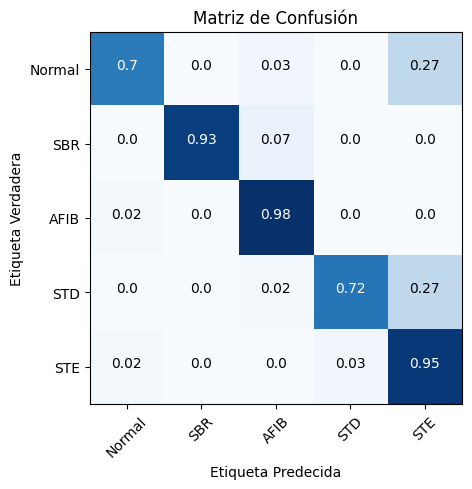

In [10]:

# cargar datos de prueba
data_test, labels_test = load_data_test_gru()
data_test=np.moveaxis(data_test,1,-2)

# Imprimiendo tamaño de test
print()

# cargar modelo previamente entrenado
model_file = 'C:\\Users\\jdani\\Documents\\TrabajoDeGrado\\Arquitecturas\\ArquitecturaRecurrente\\ModelosCheckpointsOptuna\\SN\\mejor_modelo_trial'
modelo='43'
Best_Model_GRU = keras.models.load_model(model_file+modelo+'.h5',custom_objects={'f1': f1})
# hacer la predicción
y_prediction = Best_Model_GRU.predict(data_test)
print(y_prediction)
rounded_predictions=np.argmax(y_prediction,axis=1)

# obtener matriz de confusión y graficarla
cm = confusion_matrix(y_true=labels_test, y_pred=rounded_predictions)
cm_plot_labels = ['Normal','SBR','AFIB','STD','STE']
ruta='C:\\Users\\jdani\\Documents\\TrabajoDeGrado\\Arquitecturas\\ArquitecturaRecurrente\\MatricesDeConfusion\\SN\\'
plot_confusion_matrix(cm=cm, classes=cm_plot_labels, ruta=ruta+'MatrizMejorModeloOptuna_SN.png',title='Matriz de Confusión',normalize=True)

# Entrenando modelo con los mejores Hiperparámetros

In [13]:
def create_model_gru():
    input_shape = (1, 241, 102)
    ModelGRU=keras.models.Sequential()

    ModelGRU.add(keras.layers.Conv1D(filters=229,kernel_size=24,strides=4,input_shape=input_shape[1:]))
    ModelGRU.add(keras.layers.BatchNormalization())
    ModelGRU.add(keras.layers.Activation('relu'))
    ModelGRU.add(keras.layers.Dropout(0.7))

    ModelGRU.add(keras.layers.GRU(units=128,return_sequences=True))
    ModelGRU.add(keras.layers.BatchNormalization())
    ModelGRU.add(keras.layers.Dropout(0.7))

    ModelGRU.add(keras.layers.GRU(units=128,return_sequences=True))
    ModelGRU.add(keras.layers.BatchNormalization())
    ModelGRU.add(keras.layers.Dropout(0.7))
    
    ModelGRU.add(keras.layers.TimeDistributed(keras.layers.Dense(128,activation="tanh",activity_regularizer=regularizers.L1L2(1e-3))))
    ModelGRU.add(keras.layers.Dropout(0.7))
    ModelGRU.add(keras.layers.Flatten())
    ModelGRU.add(keras.layers.Dense(64,activation="tanh",activity_regularizer=regularizers.L1L2(1e-3)))
    ModelGRU.add(keras.layers.Dropout(0.7))
    ModelGRU.add(keras.layers.Dense(5,activation="softmax",))  
    ModelGRU.summary()
    
    return ModelGRU


In [29]:
K.clear_session()
reset_keras()
data_test, labels_test_OHE,data_val, labels_val_OHE = load_data_gru()
data_val=np.moveaxis(data_val,1,-2)

# Entrenando y guardando el modelo
Best_Hiper_ModelGRU=create_model_gru()
opt = optimizers.Adam(learning_rate=0.0001202041301368352)
Best_Hiper_ModelGRU.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy',tf.keras.metrics.AUC(),f1])
ruta_modelo='C:\\Users\\jdani\\Documents\\TrabajoDeGrado\\Arquitecturas\\ArquitecturaRecurrente\\ModelosCheckpointsMejoresHiperparametros\\SN\\'
ruta_modelo_trial=ruta_modelo+'mejor_modelo_RNN_SN.h5'
Checkpoint = ModelCheckpoint(ruta_modelo_trial, monitor="val_accuracy", save_best_only=True, mode="max")
history=Best_Hiper_ModelGRU.fit(data_test,labels_test_OHE,verbose=1,epochs=30,batch_size=95,validation_data=(data_val,labels_val_OHE),callbacks=[Checkpoint])

49824
(360, 51, 241, 2)
Tamaño datos entrenamiento: (10015, 102, 241)
Tamaño etiquetas de entrenamiento: (10015,)
Tamaño datos test: (300, 102, 241)
Tamaño etiquetas de test: (300,)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 55, 229)           560821    
                                                                 
 batch_normalization (BatchN  (None, 55, 229)          916       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 55, 229)           0         
                                                                 
 dropout (Dropout)           (None, 55, 229)           0         
                                                                 
 gru (GRU)                   (None, 55, 128)           137856    
      

# Graficas modelo con los mejores hiperparámetros

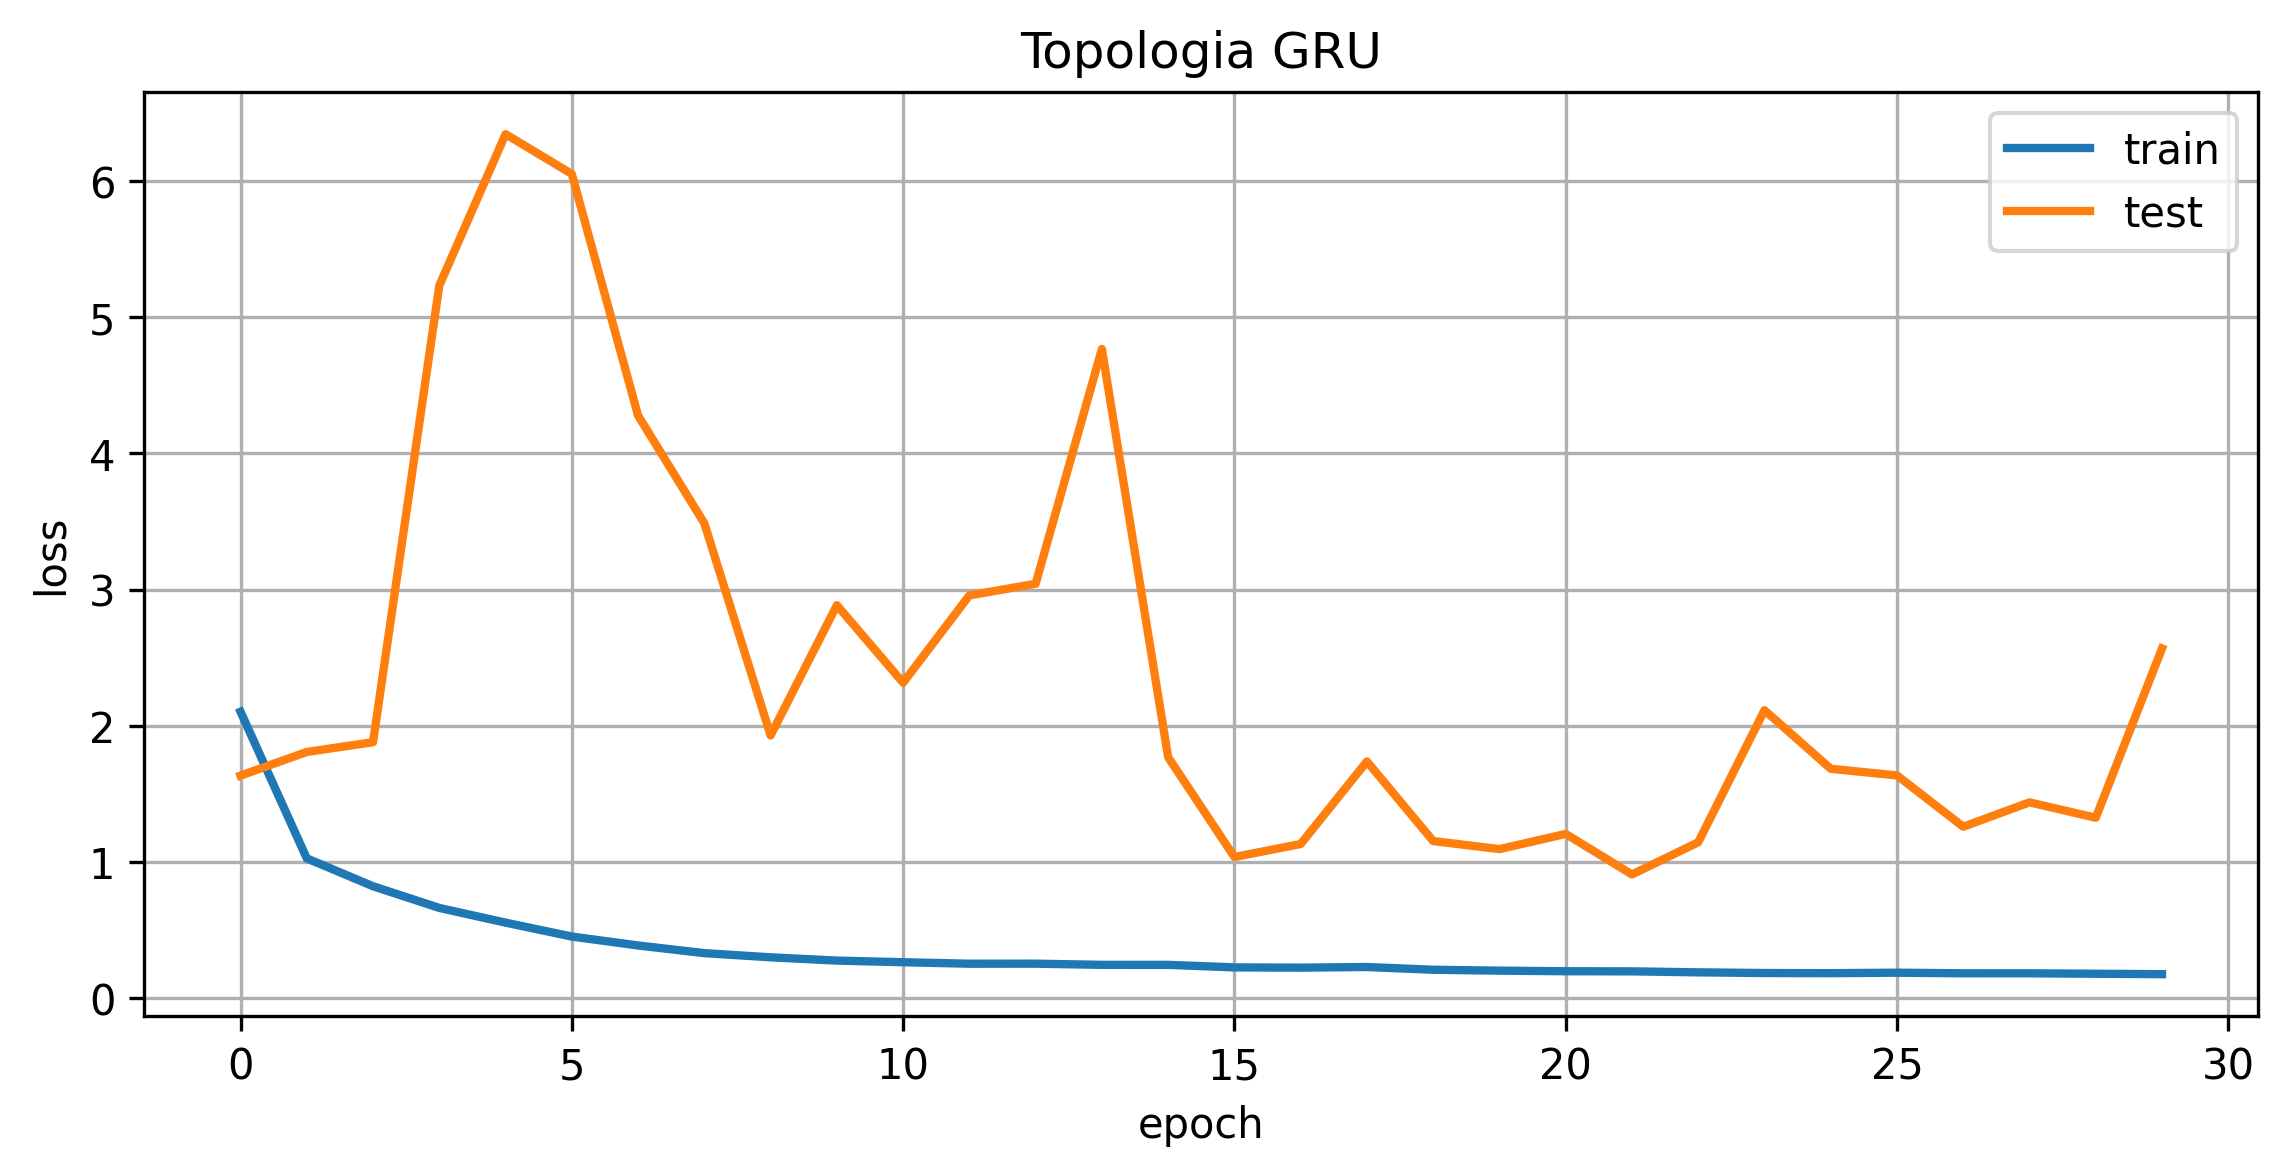

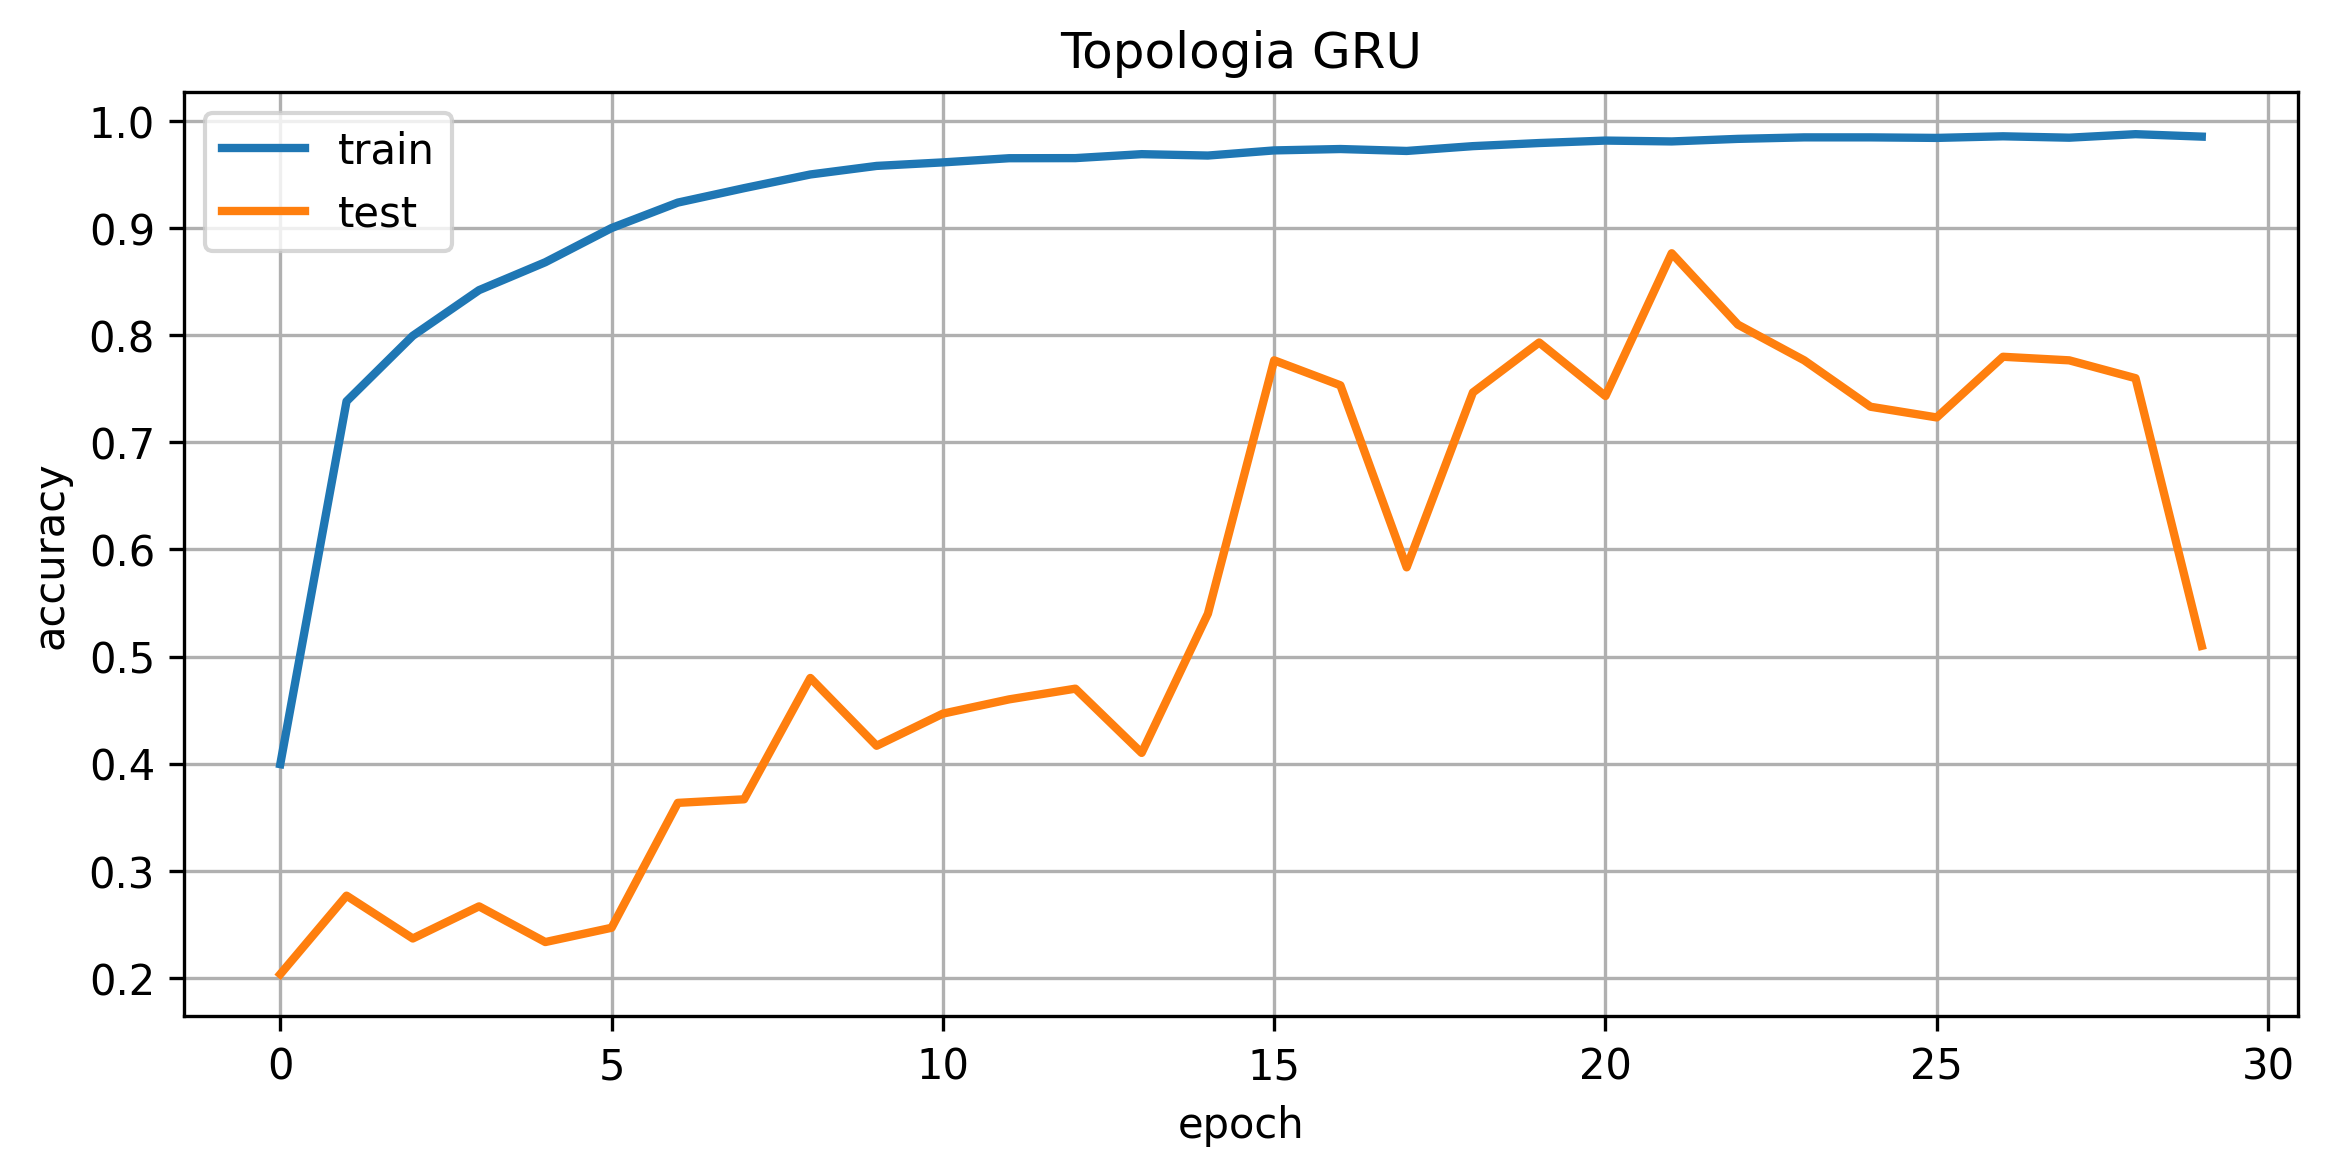

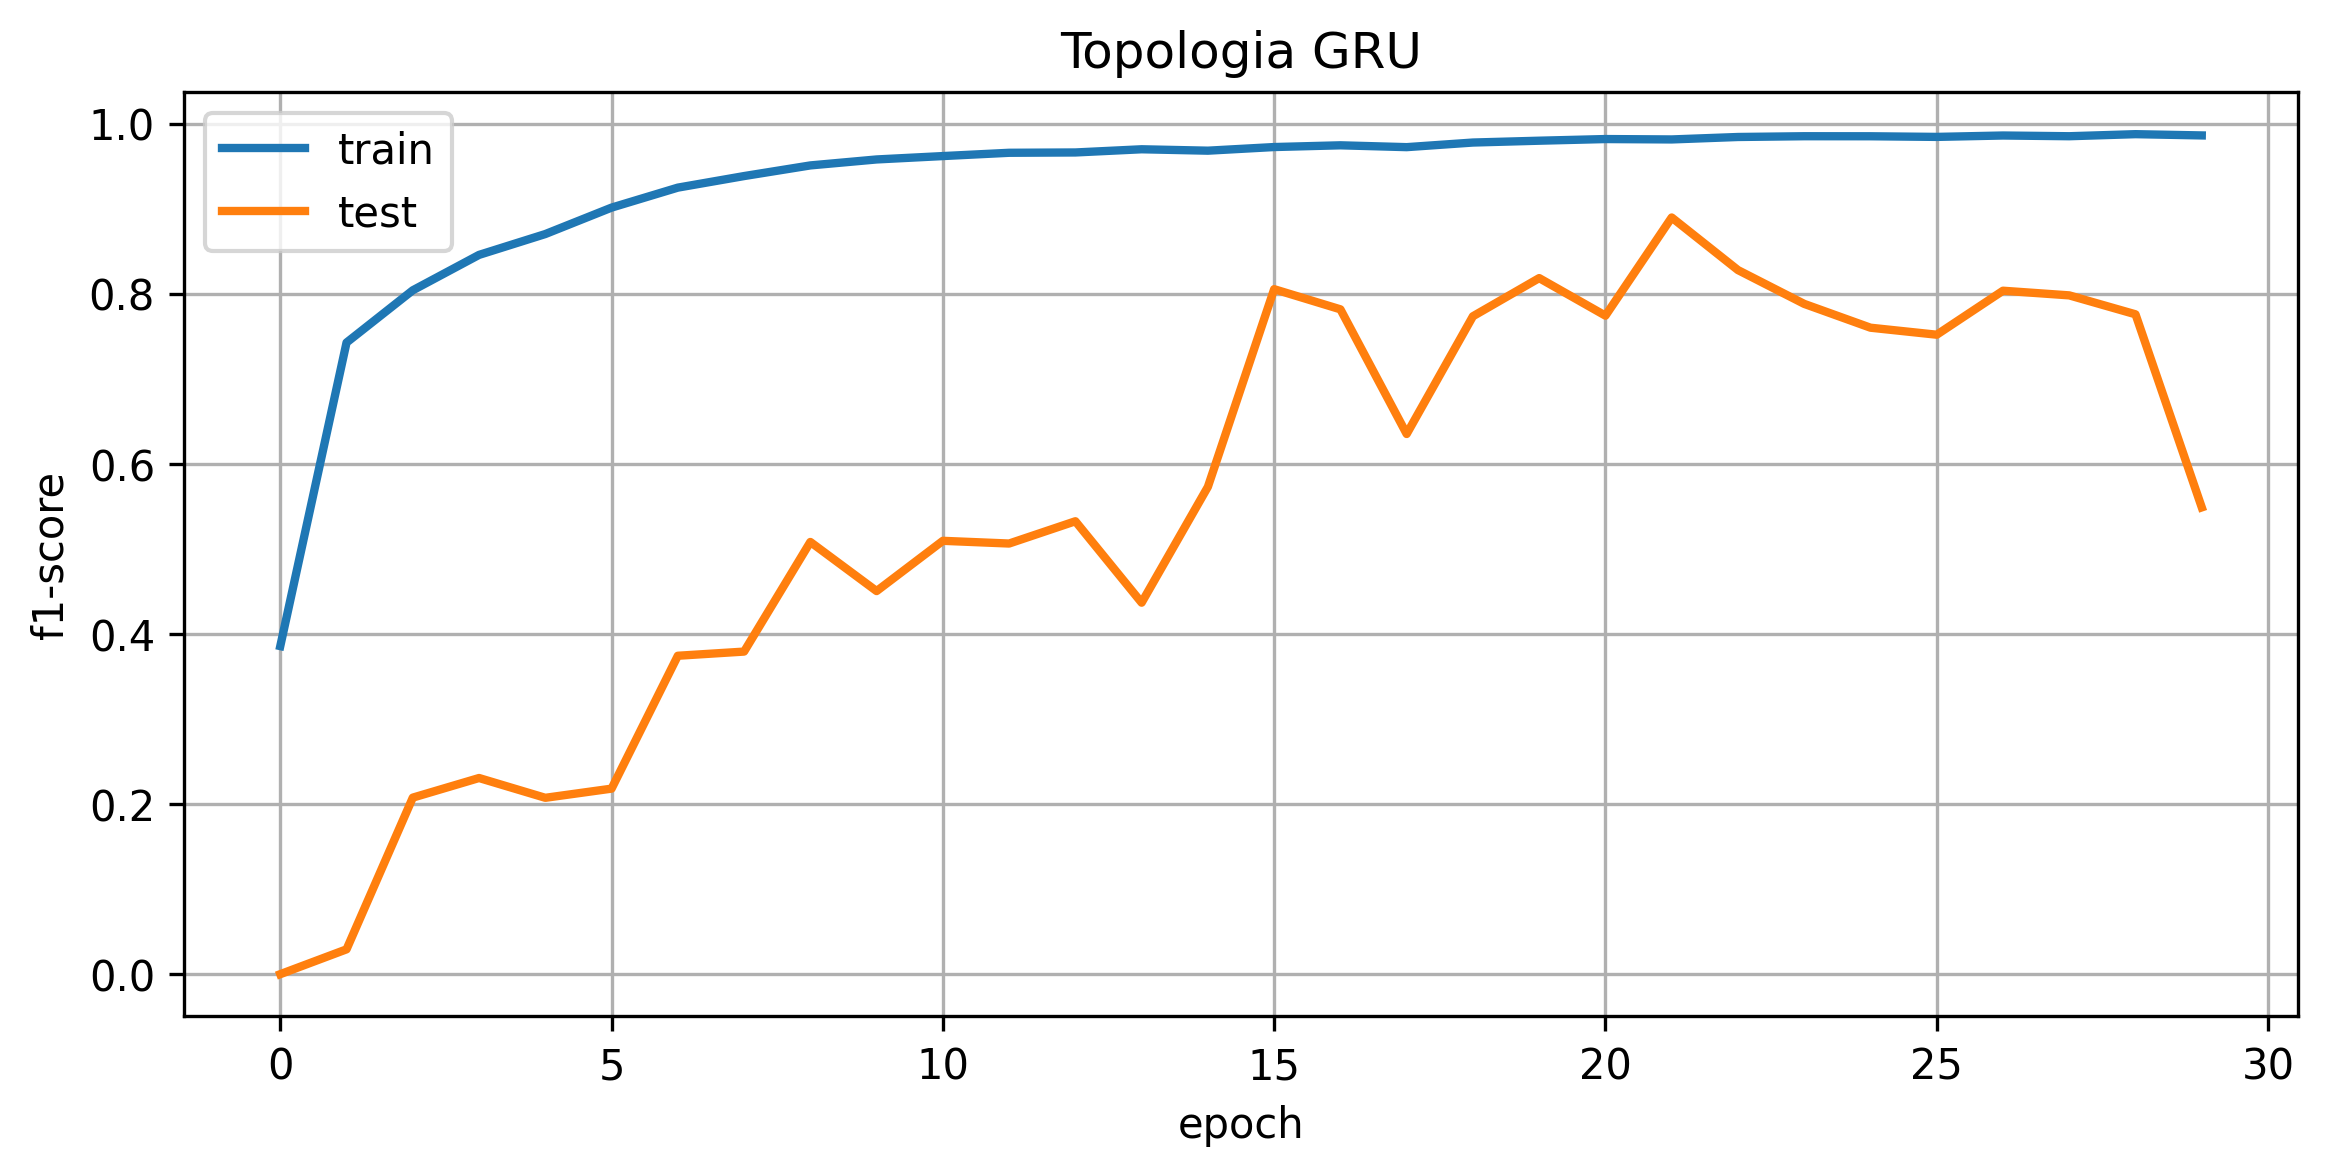

In [30]:
plt.figure(figsize=(20, 4),dpi=300)
plt.subplot(1,2,1)
plt.plot(history.history['loss'], linewidth=2, )
plt.plot(history.history['val_loss'], linewidth=2)
plt.title('Topologia GRU')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'])
plt.grid()
plt.show()

plt.figure(figsize=(20, 4),dpi=300)
plt.subplot(1,2,2)
plt.plot(history.history['accuracy'], linewidth=2,)
plt.plot(history.history['val_accuracy'], linewidth=2,)
plt.title('Topologia GRU')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'])
plt.grid()
plt.show()

plt.figure(figsize=(20, 4),dpi=300)
plt.subplot(1,2,2)
plt.plot(history.history['f1'], linewidth=2,)
plt.plot(history.history['val_f1'], linewidth=2,)
plt.title('Topologia GRU')
plt.ylabel('f1-score')
plt.xlabel('epoch')
plt.legend(['train','test'])
plt.grid()
plt.show()


Tamaño datos test: (300, 102, 241)
Tamaño etiquetas de test: (300,)
10/10 [==============================] - 1s 21ms/step
[[5.18726766e-01 6.72362861e-04 2.02221374e-04 1.30880580e-04
  4.80267763e-01]
 [1.69723202e-02 3.92018956e-05 3.85849671e-05 2.89759511e-04
  9.82660115e-01]
 [6.89254375e-04 3.64403495e-05 3.56743076e-05 1.71362131e-04
  9.99067247e-01]
 ...
 [2.04611628e-04 3.79307203e-05 6.96511270e-05 2.18572008e-04
  9.99469221e-01]
 [1.34419149e-03 2.47604748e-05 6.95247727e-05 1.17423064e-04
  9.98444140e-01]
 [1.83409313e-04 3.96058131e-05 7.27969309e-05 2.30412828e-04
  9.99473751e-01]]
Normalized confusion matrix
[[0.47 0.   0.08 0.02 0.43]
 [0.6  0.18 0.   0.   0.22]
 [0.12 0.   0.52 0.   0.37]
 [0.   0.   0.02 0.35 0.63]
 [0.   0.   0.   0.   1.  ]]


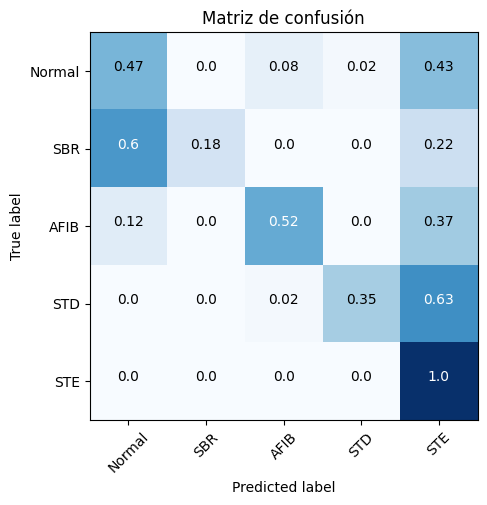

In [31]:
data_test, labels_test = load_data_test_gru()
data_test=np.moveaxis(data_test,1,-2)
y_prediction = Best_Hiper_ModelGRU.predict(data_test)
print(y_prediction)
rounded_predictions=np.argmax(y_prediction,axis=1)
cm = confusion_matrix(y_true=labels_test, y_pred=rounded_predictions)
cm_plot_labels = ['Normal','SBR','AFIB','STD','STE']
ruta='C:\\Users\\jdani\\Documents\\TrabajoDeGrado\\Arquitecturas\\ArquitecturaRecurrente\\MatricesDeConfusion\\SN\\MatrizDatosTestModeloEntrenadoSN.png'
plot_confusion_matrix(cm=cm, classes=cm_plot_labels,ruta=ruta, title='Matriz de confusión',normalize=True)

# Mejor modelo entrenado del modelo de hiperparámetros

Tamaño datos test: (300, 102, 241)
Tamaño etiquetas de test: (300,)
10/10 [==============================] - 1s 16ms/step
[[9.9914420e-01 3.1643390e-04 7.2749826e-05 3.1320938e-06 4.6345560e-04]
 [9.7224337e-01 1.8296991e-05 2.7046748e-03 6.1001873e-04 2.4423750e-02]
 [9.9323517e-01 1.1147978e-05 1.0055627e-03 3.9121250e-04 5.3569572e-03]
 ...
 [2.4490600e-04 3.1886386e-05 6.0094400e-05 1.7779812e-04 9.9948525e-01]
 [1.0574544e-03 3.4336641e-04 1.6443120e-05 2.8193634e-02 9.7038907e-01]
 [2.0269537e-04 2.6156029e-05 8.8975154e-05 1.9438891e-04 9.9948776e-01]]
Normalized confusion matrix
[[0.83 0.   0.03 0.   0.13]
 [0.   1.   0.   0.   0.  ]
 [0.05 0.02 0.93 0.   0.  ]
 [0.   0.03 0.03 0.72 0.22]
 [0.02 0.   0.   0.   0.98]]


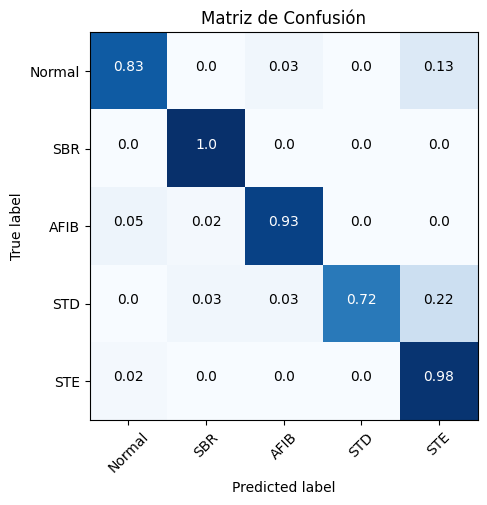

In [38]:
# cargar datos de prueba
data_test, labels_test = load_data_test_gru()
# data_test=np.moveaxis(data_test,1,-2)

# cargar modelo previamente entrenado
model_file = 'C:\\Users\\jdani\\Documents\\TrabajoDeGrado\\Arquitecturas\\ArquitecturaRecurrente\\ModelosCheckpointsMejoresHiperparametros\\SN\\'
ModelGRU_best = keras.models.load_model(model_file+'mejor_modelo_RNN_SN.h5',custom_objects={"f1": f1})
# hacer la predicción
y_prediction = ModelGRU_best.predict(data_test)
print(y_prediction)
rounded_predictions=np.argmax(y_prediction,axis=1)

# obtener matriz de confusión y graficarla
cm = confusion_matrix(y_true=labels_test, y_pred=rounded_predictions)
cm_plot_labels = ['Normal','SBR','AFIB','STD','STE']
ruta='C:\\Users\\jdani\\Documents\\TrabajoDeGrado\\Arquitecturas\\ArquitecturaRecurrente\\MatricesDeConfusion\\SN\\\MatrizDatosTestMejorModeloEntrenadoSN.png'
plot_confusion_matrix(cm=cm, classes=cm_plot_labels,ruta=ruta,title='Matriz de Confusión',normalize=True)

# Guardando datos del modelo entrenado

In [35]:
import json
#Guardando historiales
path='C:\\Users\\jdani\\Documents\\TrabajoDeGrado\\Arquitecturas\\ArquitecturaRecurrente\\ModeloMejoresHiperparametros\\SN\\'
with open(path+'historial_Modelo_RNN_SN_final.json', 'w') as f:
    json.dump(history.history, f)

#Guardando mejor modelo
Best_Hiper_ModelGRU.save('C:\\Users\\jdani\\Documents\\TrabajoDeGrado\\Arquitecturas\\ArquitecturaRecurrente\\ModeloMejoresHiperparametros\\SN\\Modelo_RNN_SN_final.h5')
ModelGRU_best.save('C:\\Users\\jdani\\Documents\\TrabajoDeGrado\\Arquitecturas\\ArquitecturaRecurrente\\ModeloMejoresHiperparametros\\SN\\Modelo_RNN_SN_Best_final.h5')

In [5]:
import json
ruta_json='C:\\Users\\jdani\\Documents\\TrabajoDeGrado\\Arquitecturas\\ArquitecturaRecurrente\\ModeloMejoresHiperparametros\\SN\\'
archivoAcargar='historial_Modelo_RNN_SN_final.json'
with open(ruta_json+archivoAcargar, 'r') as archivo_json:
    datos = json.load(archivo_json)

print(datos)

{'loss': [2.103771686553955, 1.0273911952972412, 0.822982907295227, 0.6639941334724426, 0.5560002326965332, 0.4539063572883606, 0.3883693516254425, 0.3322199881076813, 0.30149951577186584, 0.2775045335292816, 0.26556462049484253, 0.25455787777900696, 0.2548748850822449, 0.24627357721328735, 0.24619993567466736, 0.2275586575269699, 0.22570516169071198, 0.23046143352985382, 0.21026384830474854, 0.20362062752246857, 0.19928596913814545, 0.19850675761699677, 0.1912548840045929, 0.18620340526103973, 0.18515393137931824, 0.1886366307735443, 0.18428564071655273, 0.18420645594596863, 0.18097266554832458, 0.17787252366542816], 'accuracy': [0.3995007574558258, 0.7383924126625061, 0.7996006011962891, 0.8422366380691528, 0.8682975769042969, 0.9002496004104614, 0.9240139722824097, 0.9374937415122986, 0.9502745866775513, 0.9582626223564148, 0.9615576863288879, 0.9654518365859985, 0.9655516743659973, 0.9692461490631104, 0.9679480791091919, 0.972740888595581, 0.9740389585494995, 0.9722416400909424, 0.

In [6]:
import numpy as np
index_max=np.argmax(datos['val_accuracy'])
print('val_accuracy:',datos['val_accuracy'][index_max]*100)

index_max=np.argmax(datos['accuracy'])
print('accuracy:',datos['accuracy'][index_max]*100)

index_max=np.argmax(datos['val_f1'])
print('val_f1:',datos['val_f1'][index_max]*100)

index_max=np.argmax(datos['f1'])
print('f1:',datos['f1'][index_max]*100)

index_max=np.argmax(datos['val_auc'])
print('val_auc:',datos['val_auc'][index_max]*100)

index_max=np.argmax(datos['auc'])
print('auc:',datos['auc'][index_max]*100)

val_accuracy: 87.66666650772095
accuracy: 98.79181385040283
val_f1: 88.95277380943298
f1: 98.7486481666565
val_auc: 93.27208399772644
auc: 99.94220733642578


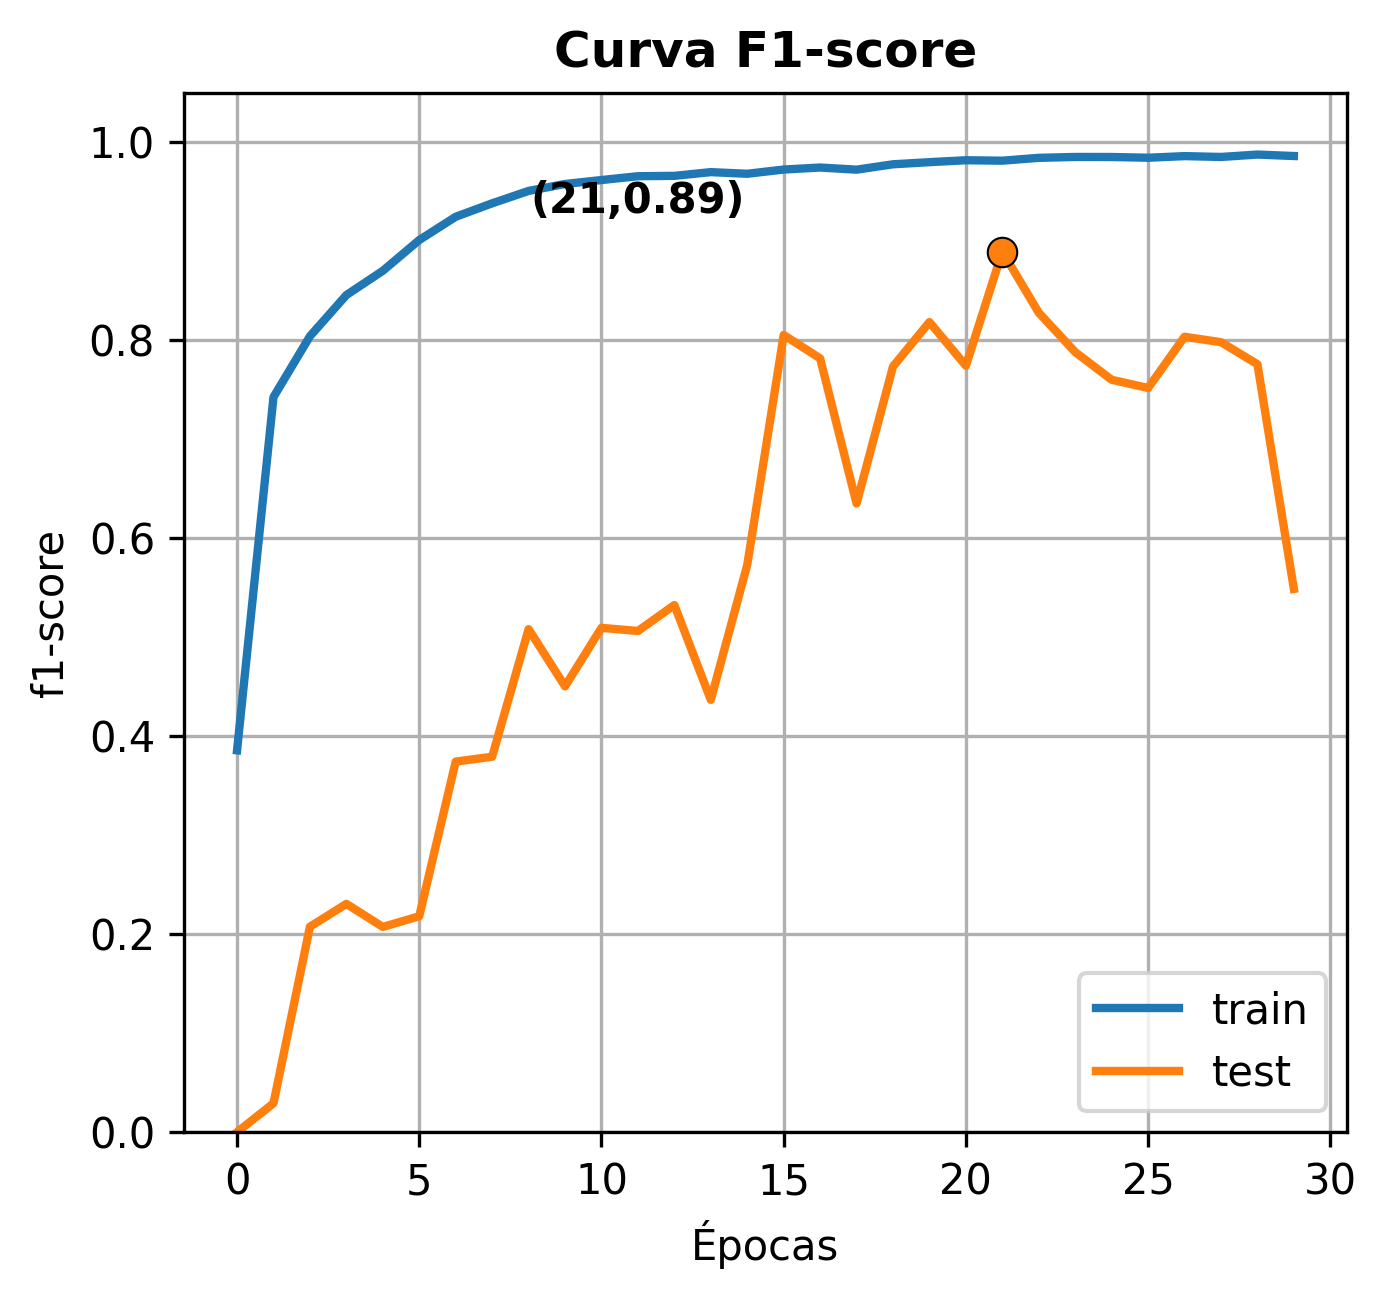

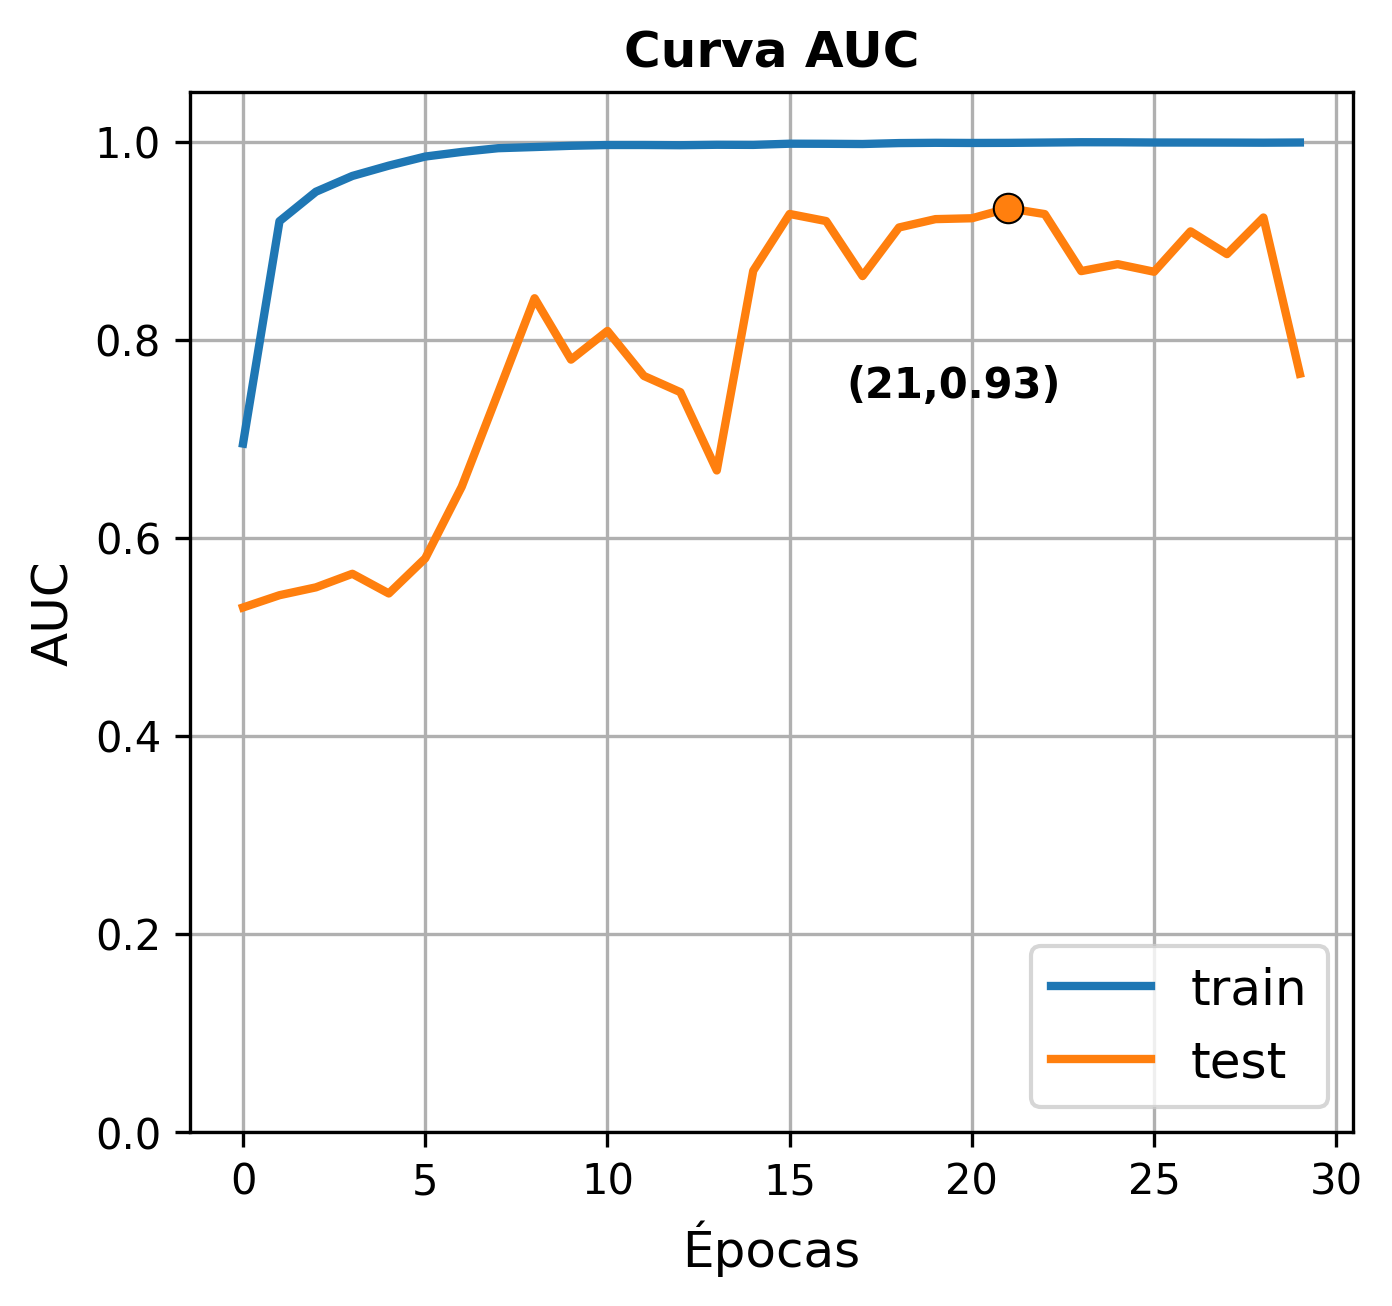

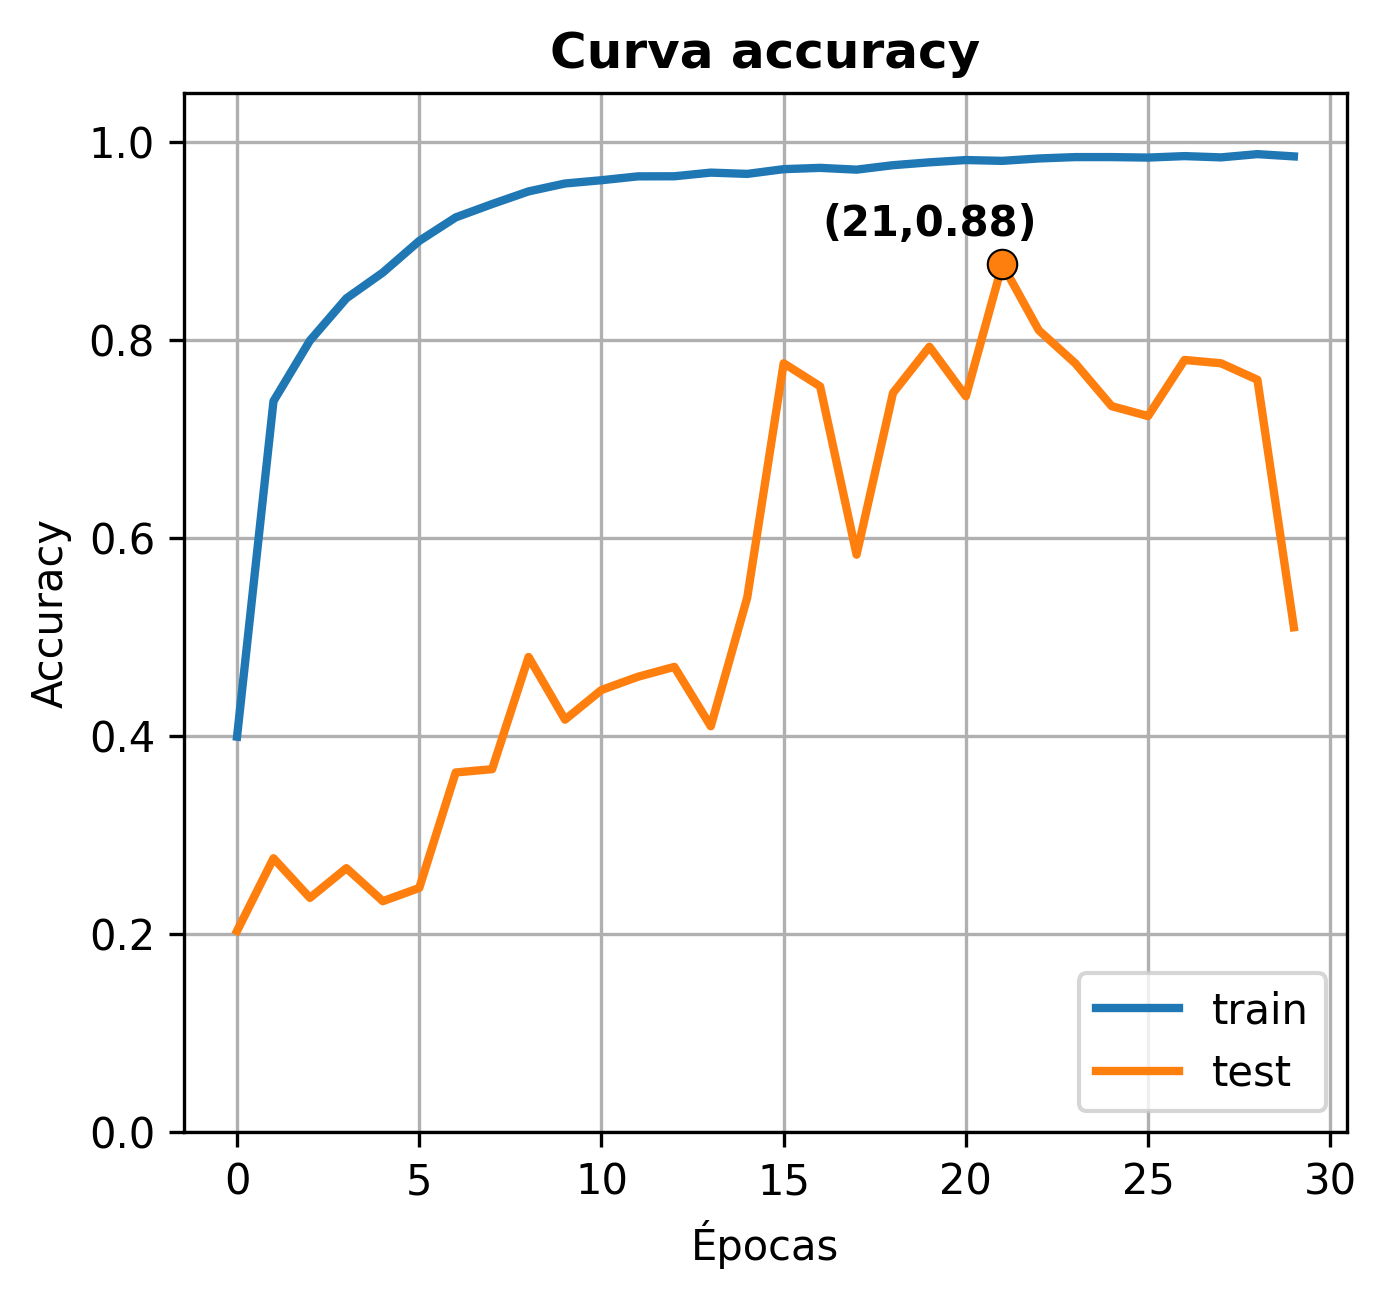

In [4]:
import matplotlib.pyplot as plt
import numpy as np
# Crear una nueva figura con solo la subfigura 3
fig2, ax2 = plt.subplots(figsize=(5,4.5), dpi=300)
ax2.plot(datos['f1'], linewidth=2,)
ax2.plot(datos['val_f1'], linewidth=2,color='#FF7F0E')
ax2.set_ylabel('f1-score')
ax2.set_xlabel('Épocas')
ax2.legend(['train', 'test'],loc='lower right')
ax2.grid()

# Encontrar el índice y el valor máximo
index_max = np.argmax(datos['val_f1'])
y_max = datos['val_f1'][index_max]
t_max = index_max

# Plotear el punto relleno en el valor máximo y agregar la etiqueta
ax2.scatter(t_max, y_max, color='#FF7F0E', edgecolors='k', linewidths=0.5, s=50, zorder=3)
ax2.text(t_max-10, y_max+0.03, f'({t_max},{y_max:.2f})', ha='center', va='bottom', color='k',fontweight='bold')

# Establecer el rango máximo en el eje Y
y_max = 1.05
ax2.set_ylim([0, y_max])

plt.title('Curva F1-score',fontweight='bold')

# Guardar la figura en un archivo separado
plt.savefig('C:\\Users\\jdani\\Documents\\TrabajoDeGrado\\Arquitecturas\\ArquitecturaRecurrente\\Imagenes\\SN\\subfigura2.png', dpi=300)

# Mostrar la figura
plt.show()



# Crear una nueva figura con solo la subfigura 3
fig2, ax2 = plt.subplots(figsize=(5,4.5), dpi=300)
ax2.plot(datos['auc'], linewidth=2,)
ax2.plot(datos['val_auc'], linewidth=2,color='#FF7F0E')
ax2.set_ylabel('AUC',fontsize=12)
ax2.set_xlabel('Épocas',fontsize=12)
ax2.legend(['train', 'test'],loc='lower right',fontsize=12)
ax2.grid()

# Encontrar el índice y el valor máximo
index_max = np.argmax(datos['val_auc'])
y_max = datos['val_auc'][index_max]
t_max = index_max

# Plotear el punto relleno en el valor máximo y agregar la etiqueta
ax2.scatter(t_max, y_max, color='#FF7F0E', edgecolors='k', linewidths=0.5, s=50, zorder=3)
ax2.text(t_max-1.5, y_max-0.2, f'({t_max},{y_max:.2f})', ha='center', va='bottom', color='k',fontweight='bold')

# Establecer el rango máximo en el eje Y
y_max = 1.05
ax2.set_ylim([0, y_max])

plt.title('Curva AUC',fontweight='bold')

# Guardar la figura en un archivo separado
plt.savefig('C:\\Users\\jdani\\Documents\\TrabajoDeGrado\\Arquitecturas\\ArquitecturaRecurrente\\Imagenes\\SN\\subfigura3.png', dpi=300)

# Mostrar la figura
plt.show()

# Crear una nueva figura con solo la subfigura 3
fig2, ax2 = plt.subplots(figsize=(5,4.5), dpi=300)
ax2.plot(datos['accuracy'], linewidth=2,)
ax2.plot(datos['val_accuracy'], linewidth=2,color='#FF7F0E')
ax2.set_ylabel('Accuracy')
ax2.set_xlabel('Épocas')
ax2.legend(['train', 'test'],loc='lower right')
ax2.grid()

# Encontrar el índice y el valor máximo
index_max = np.argmax(datos['val_accuracy'])
y_max = datos['val_accuracy'][index_max]
t_max = index_max

# Plotear el punto relleno en el valor máximo y agregar la etiqueta
ax2.scatter(t_max, y_max, color='#FF7F0E', edgecolors='k', linewidths=0.5, s=50, zorder=3)
ax2.text(t_max-2, y_max+0.02, f'({t_max},{y_max:.2f})', ha='center', va='bottom', color='k',fontweight='bold')

# Establecer el rango máximo en el eje Y
y_max = 1.05
ax2.set_ylim([0, y_max])

plt.title('Curva accuracy',fontweight='bold')

# Guardar la figura en un archivo separado
plt.savefig('C:\\Users\\jdani\\Documents\\TrabajoDeGrado\\Arquitecturas\\ArquitecturaRecurrente\\Imagenes\\SN\\subfigura1.png', dpi=300)

# Mostrar la figura
plt.show()